<a href="https://colab.research.google.com/github/vzeizer/Unsupervised_CHURN/blob/master/CHURN_AMBEV_UNSUPERVISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tackling a Churn problem using Unsupervised Learning**

- In this notebook, the Ambev Data Science Challenge will be tackled by using a unsupervised learning approach.


**Data Dictionary:**

1. **customer_code**: Unique identifier for each customer.

2. **branch_id**: Identifier for the branch associated with the transaction.

3. **sales_channel**: Channel through which the sale was made (e.g., online, in-store, etc.).

4. **seller_code**: Identifier for the seller involved in the transaction.

5. **register_date**: Date when the customer registered.

6. **total_price**: Total price of the transaction.

7. **order_id**: Identifier for the order associated with the transaction.

8. **quantity**: Number of items purchased in the transaction.

9. **item_code**: Identifier for the item purchased.

10. **item_total_price**: Total price of the item in the transaction.

11. **unit_price**: Price per unit of the item.

12. **group_code**: Code indicating the group/category to which the item belongs.

13. **segment_code**: Code indicating the segment to which the item belongs.

14. **is_churn (Target)**: Binary variable indicating whether the customer churned (1) or not (0).


## Possible Unsupervised Learning Approaches

1. **Customer Segmentation Based on Transaction Behavior**:

- Features to Use: total_price, quantity, item_code (number of unique items), group_code (most frequent groups), segment_code (most frequent segments), average item_total_price per transaction.
- Technique: K-Means clustering would be a good starting point.
- Use Case:
- Identify spending habits: Segment customers based on their average transaction value and the total amount they spend. This can help differentiate high-value customers from occasional buyers.
Understand purchase diversity: Group customers by the variety of items, groups, or segments they purchase. Some segments might be loyal to specific product categories, while others explore a wider range.
- Quantity-based segmentation: Identify customers who tend to buy in bulk versus those who purchase single items. This could inform inventory management and targeted offers.

2. **Segmentation Based on Registration and Channel**:

- Features to Use: register_date (recency of registration, time since registration), sales_channel.
- Technique: K-Means or even exploring descriptive statistics for groups defined by sales_channel.
- Use Case:
- New vs. Established Customers: Segment customers based on how long they've been registered. Newer customers might have different needs and churn patterns than long-term ones.
- Channel-Specific Customer Profiles: Understand if customers acquired through different sales_channel exhibit distinct purchasing behaviors in terms of price, quantity, or item preferences. This can inform channel-specific marketing strategies.

3. **Item Grouping and Recommendation Exploration**:

- Features to Use: item_code, group_code, segment_code.
- Technique: Association rule mining (like Apriori) or clustering items based on co-occurrence in transactions.
- Use Case:
- Discover frequently bought together items: Identify items that are often purchased in the same order. This can be used for cross-selling recommendations (e.g., "Customers who bought X also bought Y").
- Group similar items: Cluster item_code based on their group_code and segment_code to identify natural groupings. This can help in catalog organization and understanding product relationships.

4. **Identifying Potential Anomalies in Transactions**:

- Features to Use: total_price, quantity, item_total_price, unit_price.
- Technique: Isolation Forest or DBSCAN.
- Use Case:
- Detect unusual order values: Identify transactions with exceptionally high or low total_price or quantity compared to the typical order. This could flag potential errors or fraudulent activities.
- Unusual unit prices: Spot transactions where the unit_price deviates significantly from the norm for a particular item_code.

5. **Exploring Seller or Branch Performance Patterns**:

- Features to Use: seller_code, branch_id, aggregate features like average total_price per transaction, average quantity per transaction associated with each seller or branch.
- Technique: Clustering based on these aggregated features.
- Use Case:
- Identify high-performing vs. low-performing sellers/branches: Group sellers or branches based on their average sales value or transaction volume.
- Understand regional or seller-specific purchasing patterns: See if certain branches or sellers tend to have customers with different average order sizes or item preferences.


## Important Considerations:

- Data Aggregation: For some use cases (like seller/branch performance), you'll need to aggregate the transaction-level data to the seller or branch level.
- Feature Scaling: Remember to scale numerical features before applying distance-based algorithms like K-Means to prevent features with larger ranges from dominating the clustering process.
- Categorical Feature Handling: For categorical features like sales_channel, group_code, and segment_code, you might need to use appropriate distance metrics for clustering or encode them (e.g., one-hot encoding) depending on the algorithm.
- Interpretation is Key: The most crucial step is to interpret the resulting clusters or anomalies in the context of your business. What do these groupings mean? What are the characteristics of the anomalous transactions?

## **Approach 1: Customer Segmentation Based on Transaction Behavior**:


- Features to Use: total_price, quantity, item_code (number of unique items), group_code (most frequent groups), segment_code (most frequent segments), average item_total_price per transaction.
- Technique: K-Means clustering would be a good starting point.
- Use Case:
- Identify spending habits: Segment customers based on their average transaction value and the total amount they spend. This can help differentiate high-value customers from occasional buyers.
- Understand purchase diversity: Group customers by the variety of items, groups, or segments they purchase. Some segments might be loyal to specific product categories, while others explore a wider range.
- Quantity-based segmentation: Identify customers who tend to buy in bulk versus those who purchase single items. This could inform inventory management and targeted offers.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# opening the data
df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")
# Select the features for customer segmentation based on transaction behavior
features_for_segmentation = ['total_price', 'quantity', 'item_code', 'group_code', 'segment_code', 'item_total_price','order_id', 'is_churn']

# Handle missing values (if any) - for simplicity, we'll drop them here
df_segmentation = df[features_for_segmentation].dropna().copy()


# For 'item_code', 'group_code', 'segment_code', let's get the count of unique values per order
# We'll group by 'order_id' and then aggregate
unique_item_counts = df_segmentation.groupby('order_id')['item_code'].nunique().reset_index(name='unique_item_count')
unique_group_counts = df_segmentation.groupby('order_id')['group_code'].nunique().reset_index(name='unique_group_count')
unique_segment_counts = df_segmentation.groupby('order_id')['segment_code'].nunique().reset_index(name='unique_segment_count')

# Merge these back into our main DataFrame (assuming 'order_id' is a key in your original df)
df_segmentation = pd.merge(df_segmentation, unique_item_counts, on='order_id', how='left')
df_segmentation = pd.merge(df_segmentation, unique_group_counts, on='order_id', how='left')
df_segmentation = pd.merge(df_segmentation, unique_segment_counts, on='order_id', how='left')

# Calculate average item total price per order
avg_item_price = df_segmentation.groupby('order_id')['item_total_price'].mean().reset_index(name='avg_item_total_price')
df_segmentation = pd.merge(df_segmentation, avg_item_price, on='order_id', how='left')


In [ ]:
df_segmentation.head(5)

,total_price,quantity,item_code,group_code,segment_code,item_total_price,order_id,is_churn,unique_item_count,unique_group_count,unique_segment_count,avg_item_total_price
0,1613.53,10,854,0,0,292.91,21804,0.0,13,1,1,144.645385
1,11163.69,20,246,0,5,287.19,5486,0.0,29,1,1,449.403448
2,6432.12,12,1420,0,0,184.84,22662,0.0,29,1,1,254.793103
3,831.82,18,1963,0,0,189.18,3956,0.0,5,1,1,166.364000
4,1736.48,5,1786,0,0,66.87,4730,0.0,14,1,1,138.960714


In [ ]:
df_segmentation.describe()

,total_price,quantity,item_code,group_code,segment_code,item_total_price,order_id,is_churn,unique_item_count,unique_group_count,unique_segment_count,avg_item_total_price
count,202513.000000,202513.000000,202513.000000,202513.000000,202513.000000,202513.000000,202513.000000,202513.000000,202513.000000,202513.0,202513.0,202513.000000
mean,5359.461460,12.353681,1437.736560,0.281720,0.788191,304.389862,12430.877242,0.191168,14.317530,1.0,1.0,304.389862
std,21366.655475,53.524542,903.650915,0.668072,1.507950,1013.308355,6929.426518,0.393222,10.832725,0.0,0.0,617.228066
min,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,0.010000
25%,1179.160000,3.000000,631.000000,0.000000,0.000000,79.600000,6511.000000,0.000000,8.000000,1.0,1.0,133.758000
50%,2033.140000,6.000000,1455.000000,0.000000,0.000000,156.090000,12694.000000,0.000000,12.000000,1.0,1.0,198.323000
75%,3604.640000,12.000000,2049.000000,0.000000,1.000000,293.730000,18262.000000,0.000000,18.000000,1.0,1.0,294.935000
max,428976.460000,7000.000000,2980.000000,2.000000,6.000000,102951.110000,24617.000000,1.000000,138.000000,1.0,1.0,52500.000000


In [ ]:
df_segmentation.nunique()

,0
total_price,22499
quantity,290
item_code,2968
group_code,3
segment_code,7
item_total_price,55100
order_id,24380
is_churn,2
unique_item_count,72
unique_group_count,1


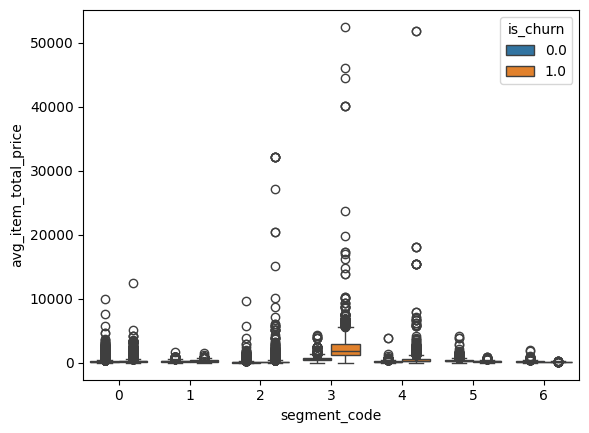

In [ ]:
plt.figure()

sns.boxplot(data=df_segmentation,y='avg_item_total_price',x='segment_code',hue='is_churn')

plt.show()

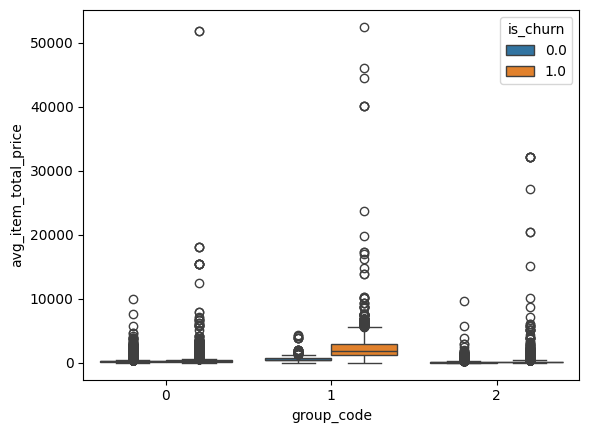

In [ ]:
plt.figure()

sns.boxplot(data=df_segmentation,y='avg_item_total_price',x='group_code',hue='is_churn')

plt.show()

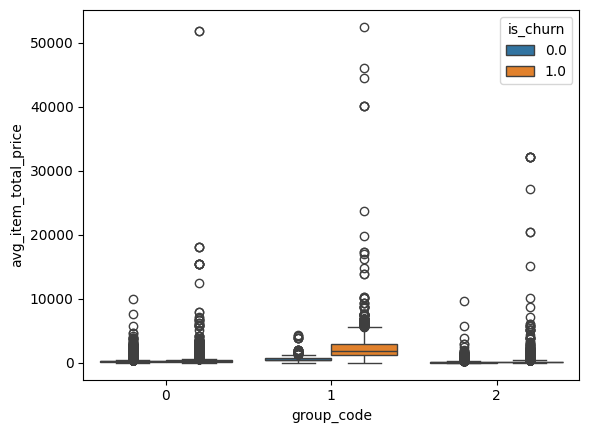

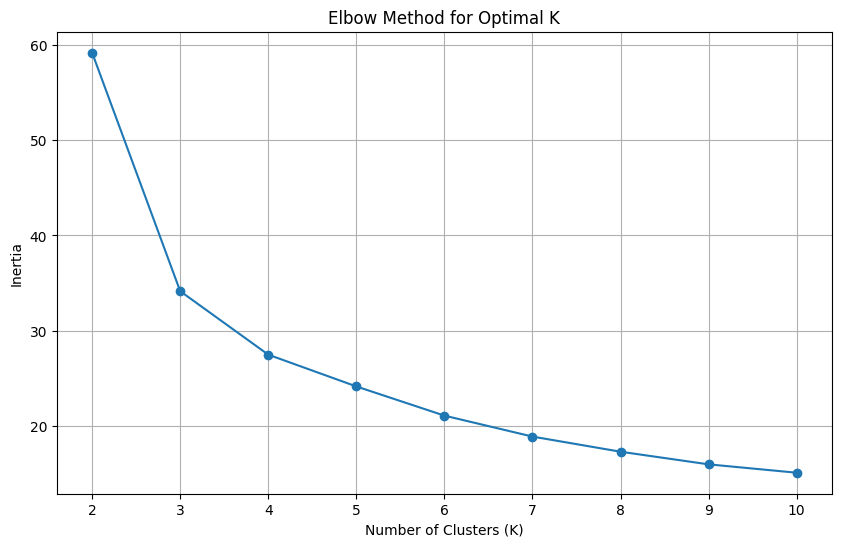


Cluster Analysis:
           total_spent  total_quantity  unique_items  unique_groups  \
cluster                                                               
0        283343.428771     1418.072626     46.525140            1.0   
1        121196.341588      628.030043     29.536481            1.0   
2        117084.751897      343.103448     28.258621            1.0   

         unique_segments  order_count  avg_order_value  avg_churn_value  
cluster                                                                  
0                    1.0    21.687151      1929.052592              0.0  
1                    1.0    11.321888      1765.941013              0.0  
2                    1.0     5.706897      2673.916666              1.0  

Cluster Sizes:
cluster
1    233
0    179
2     58
Name: count, dtype: int64


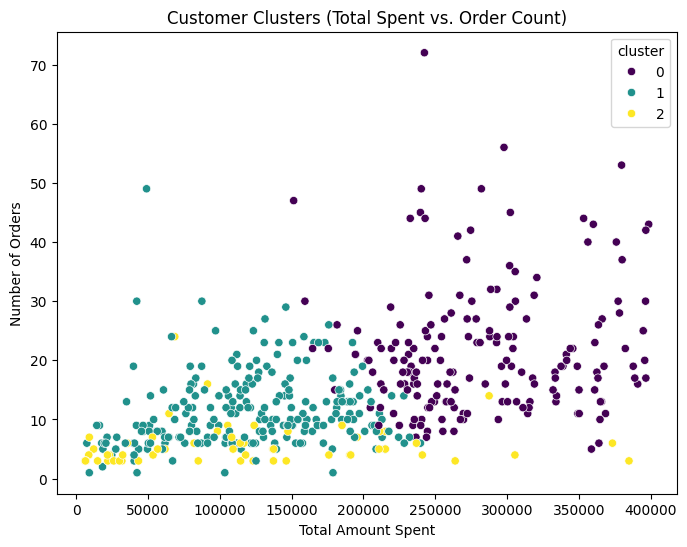

<ipython-input-68-0f6e2a204d93>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='avg_churn_value', data=customer_features, palette='viridis')


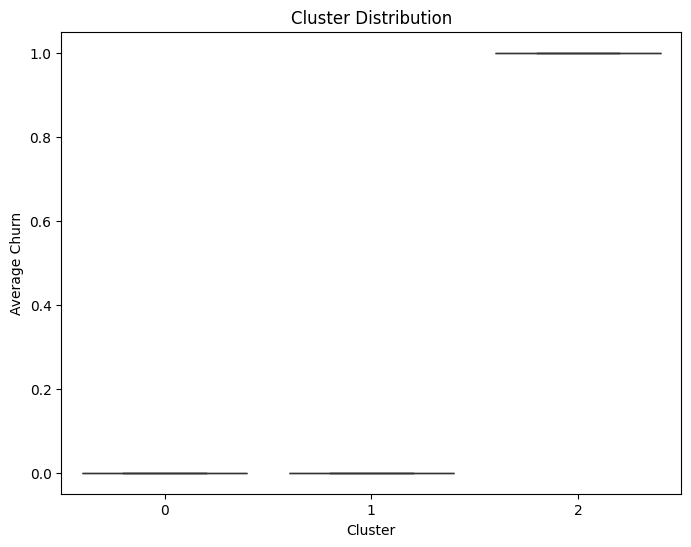

<ipython-input-68-0f6e2a204d93>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='avg_order_value', data=customer_features, palette='viridis')


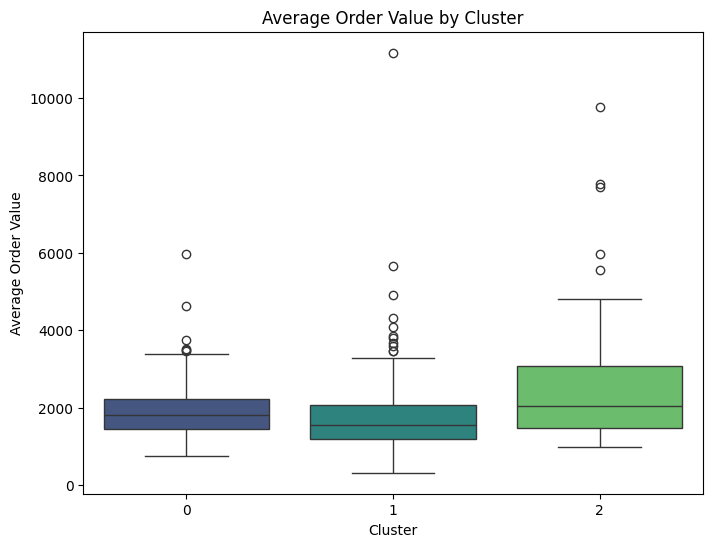

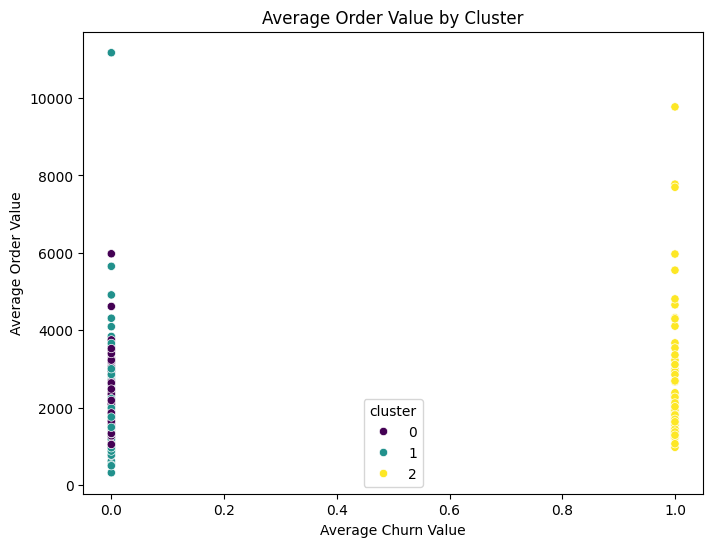

In [ ]:
plt.figure()

sns.boxplot(data=df_segmentation,y='avg_item_total_price',x='group_code',hue='is_churn')

plt.show()

# Now, for clustering customers, we likely want one row per customer.
# We can aggregate transaction-level data to the customer level using 'customer_code'
customer_features = df.groupby('customer_code').agg(
    avg_churn_value=('is_churn', lambda x: x.sum()/len(x)),
    total_spent=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    unique_items=('item_code', 'nunique'),
    unique_groups=('group_code', lambda x: x.nunique()),
    unique_segments=('segment_code', lambda x: x.nunique()),
    order_count=('order_id', 'nunique'),
    avg_order_value=('total_price', 'mean'),

).reset_index()

# Select the features we want to use for clustering
clustering_features = ['total_spent', 'total_quantity', 'unique_items', 'unique_groups', 'unique_segments', 'order_count', 'avg_order_value', 'avg_churn_value']

X = customer_features[clustering_features].copy()

# removing an outlier
X = X[X['total_spent']<4*10**5]
customer_features = customer_features[customer_features['total_spent']<4*10**5]
X = X[X['order_count']<1*10**3]
customer_features = customer_features[customer_features['order_count']<1*10**3]

# Scale the features using StandardScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters (Elbow Method)
inertia = []
k_range = range(2, 11)  # Try a range of cluster numbers
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal number of clusters (let's say k=3 for this example)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
print("\nCluster Analysis:")
print(customer_features.groupby('cluster')[clustering_features].mean())
print("\nCluster Sizes:")
print(customer_features['cluster'].value_counts())

# Visualize the clusters (for a pair of features)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_features, x='total_spent', y='order_count', hue='cluster', palette='viridis')
plt.title('Customer Clusters (Total Spent vs. Order Count)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Orders')
plt.show()

# You can create more visualizations for other pairs of features to understand the clusters better

plt.figure(figsize=(8, 6))

sns.boxplot(x='cluster', y='avg_churn_value', data=customer_features, palette='viridis')

plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Average Churn')

plt.show()

plt.figure(figsize=(8, 6))

sns.boxplot(x='cluster', y='avg_order_value', data=customer_features, palette='viridis')

plt.title('Average Order Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Order Value')

plt.show()

plt.figure(figsize=(8, 6))

sns.scatterplot(data=customer_features, y='avg_order_value', x='avg_churn_value', hue='cluster', palette='viridis')

plt.title('Average Order Value by Cluster')
plt.xlabel('Average Churn Value')
plt.ylabel('Average Order Value')
plt.show()



## **Explanation**:

- Feature Selection (Initial): We initially selected features related to transaction behavior.
- Feature Engineering (Aggregation to Customer Level): The key here is to move from transaction-level data to customer-level data for segmentation. We group the DataFrame by customer_code and calculate aggregate features like:

1. total_spent: Total amount spent by the customer.
2. total_quantity: Total quantity of items purchased.
3. unique_items: Number of unique items purchased.
4. unique_groups: Number of unique item groups purchased.
5. unique_segments: Number of unique item segments purchased.
6. order_count: Total number of orders placed.
7. avg_order_value: Average value of their orders.

- Feature Scaling: We use StandardScaler to standardize the features. This is crucial for K-Means as it's a distance-based algorithm, and features with larger scales can disproportionately influence the clustering.
- Determining Optimal Number of Clusters (Elbow Method):
- We iterate through a range of possible cluster numbers (from 2 to 10 in this example).
- For each number of clusters, we train a K-Means model and calculate the inertia_ (within-cluster sum of squared distances).
We plot the inertia values against the number of clusters. The "elbow" point in this plot (where the rate of decrease in inertia starts to slow down) can give you an indication of a good number of clusters.
- Applying K-Means Clustering:
1. Based on the elbow method (you'll need to examine the plot), choose the optimal_k (number of clusters). I've set it to 3 as an example.
2. Initialize and fit the KMeans model with the scaled data.
3. Assign the cluster labels to each customer in the customer_features DataFrame.
- Cluster Analysis:
1. We group the customer_features DataFrame by the assigned cluster and calculate the mean of the clustering features for each cluster. This helps you understand the characteristics of each segment.
2. We also print the size of each cluster to see how many customers fall into each segment.
Visualization:
3. We create a scatter plot to visualize the clusters based on two of the features (total_spent and order_count). You can create similar plots for other pairs of features to gain different perspectives on the clusters.
Next Steps:

## Results Interpretation

1. Examine the elbow plot to determine the optimal number of clusters for your data.

Ans: Three clusters seem to be a good number for the number of clusters.

2. Analyze the cluster characteristics. What patterns do you observe in the
mean values of the features for each cluster?

Ans: There are churn and non-churn related events related to each of the three clusters.

3. Create more visualizations to explore the clusters in different feature spaces.

Ans: Churn related events tend to higher average order price.

4. Interpret the clusters in the context of your business. What do these customer segments represent? Are there high-value segments, frequent buyers, low-spending customers, etc.?
5. Relate these clusters to churn. After identifying the clusters, you can analyze the churn rate (is_churn) within each cluster to see if certain segments have a higher propensity to churn. This would involve merging the cluster labels back with your original DataFrame containing the is_churn column.

Ans: Sure, one of the clusters is strictly related to churn events.


# **Approach 2: Segmentation Based on Registration and Channel**



- **Features to Use**: register_date (recency of registration, time since registration), sales_channel.
- Technique: **K-Means** or even exploring descriptive statistics for groups defined by sales_channel.
- Use Case:
- New vs. Established Customers: Segment customers based on how long they've been registered. Newer customers might have different needs and churn patterns than long-term ones.
- Channel-Specific Customer Profiles: Understand if customers acquired through different sales_channel exhibit distinct purchasing behaviors in terms of price, quantity, or item preferences. This can inform channel-specific marketing strategies.


Cluster Analysis (Mean Days Since Registration):
cluster
0    1370.494730
1    2859.513404
2     920.916388
3    1482.849790
Name: days_since_registration, dtype: float64

Cluster Analysis (Sales Channel Distribution):
cluster  sales_channel
0        0                0.420947
         7                0.315738
         2                0.160120
         4                0.080353
         9                0.012414
                            ...   
2        3                0.000113
         12               0.000113
         16               0.000023
         15               0.000011
3        6                1.000000
Name: proportion, Length: 122, dtype: float64

Cluster Sizes:
cluster
2    88349
1    52633
0    35767
3    25764
Name: count, dtype: int64


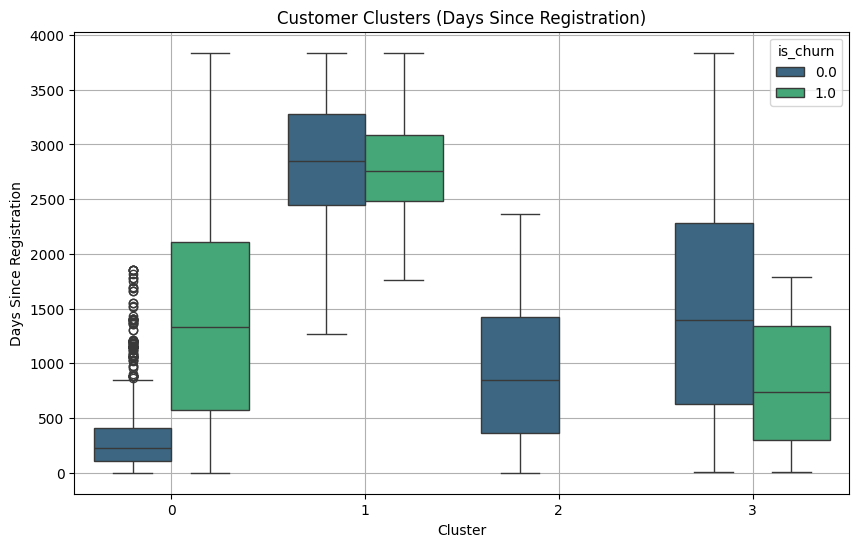

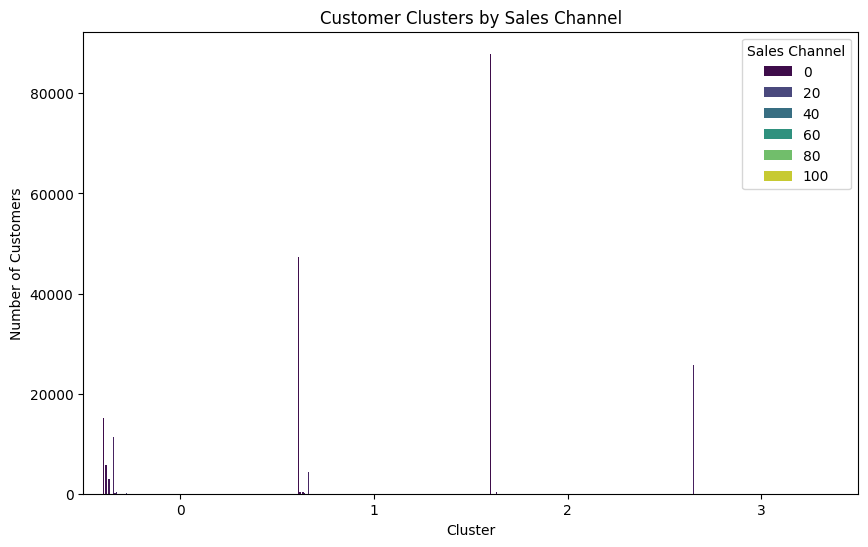

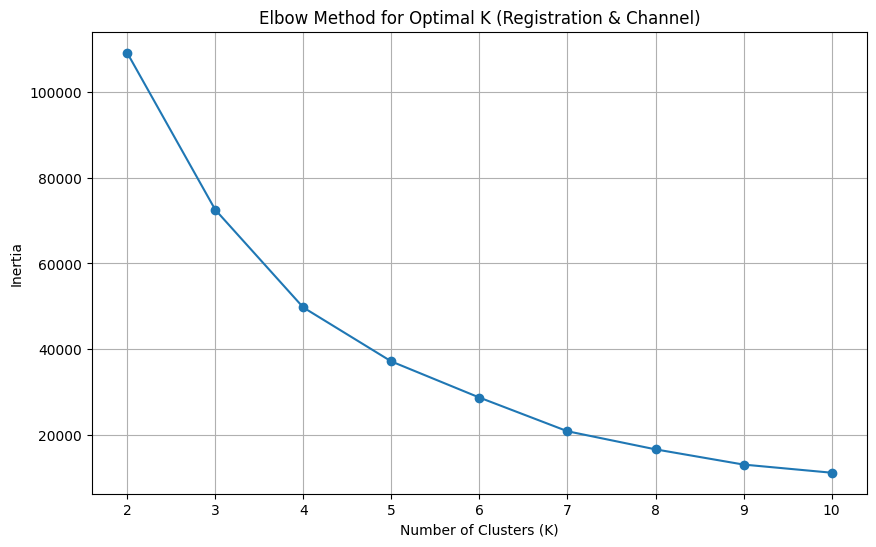

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Assuming your data is in a pandas DataFrame called 'df'
# Replace 'your_data.csv' with the actual path to your data file

# Select the features for segmentation based on registration and channel
features_for_segmentation = ['register_date', 'sales_channel', 'is_churn']
df_segmentation = df[features_for_segmentation].dropna().copy()

# Convert 'register_date' to datetime objects
df_segmentation['register_date'] = pd.to_datetime(df_segmentation['register_date'])

# Feature Engineering: Calculate time since registration (in days)
latest_date = df_segmentation['register_date'].max()
df_segmentation['days_since_registration'] = (latest_date - df_segmentation['register_date']).dt.days

# Select features for clustering
clustering_features = ['days_since_registration', 'sales_channel', 'is_churn']
X = df_segmentation[clustering_features].copy()

# Preprocessing steps
numerical_features = ['days_since_registration', 'is_churn']
categorical_features = ['sales_channel']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline for preprocessing and clustering
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('kmeans', KMeans(n_clusters=4, random_state=42, n_init=10))]) # Start with an initial guess of 3 clusters

# Fit the pipeline
pipeline.fit(X)

# Get the cluster labels
cluster_labels = pipeline.named_steps['kmeans'].labels_
df_segmentation['cluster'] = cluster_labels

# Analyze the clusters
print("\nCluster Analysis (Mean Days Since Registration):")
print(df_segmentation.groupby('cluster')['days_since_registration'].mean())

print("\nCluster Analysis (Sales Channel Distribution):")
print(df_segmentation.groupby('cluster')['sales_channel'].value_counts(normalize=True))

print("\nCluster Sizes:")
print(df_segmentation['cluster'].value_counts())

# Visualize the clusters (you might need to adapt this based on the number of channels)
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', hue='is_churn', y='days_since_registration', data=df_segmentation, palette='viridis')
plt.title('Customer Clusters (Days Since Registration)')
plt.xlabel('Cluster')
plt.ylabel('Days Since Registration')
plt.xticks(df_segmentation['cluster'].unique())
plt.grid(True)
plt.show()

# Visualize based on sales channel (as it's categorical, a count plot or bar chart might be better)
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='sales_channel', data=df_segmentation, palette='viridis')
plt.title('Customer Clusters by Sales Channel')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(df_segmentation['cluster'].unique())
plt.legend(title='Sales Channel')
plt.show()

# Determining the optimal number of clusters (Elbow Method)
inertia = []
k_range = range(2, 11)
preprocessor_elbow = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init=10)
    pipeline_elbow = Pipeline(steps=[('preprocessor', preprocessor_elbow),
                                     ('kmeans', kmeans_elbow)])
    pipeline_elbow.fit(X)
    inertia.append(pipeline_elbow.named_steps['kmeans'].inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K (Registration & Channel)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## **Explanation**:

**Data Preprocessing**:
- Convert to Datetime: Convert the register_date column to datetime objects using pd.to_datetime().
- Feature Engineering: Calculate days_since_registration by subtracting the register_date from the latest registration date in the dataset. This provides a numerical representation of how long a customer has been registered.
- Feature Preparation: Select the features for clustering.
Preprocessing with ColumnTransformer and Pipeline:
- We use ColumnTransformer to apply different preprocessing steps to numerical and categorical features.
- MinMaxScaler() is used to scale the numerical days_since_registration feature.
- OneHotEncoder() is used to encode the categorical sales_channel feature into a numerical format that K-Means can work with. handle_unknown='ignore' is used to avoid errors if new, unseen sales channels appear during prediction (though we are in an unsupervised setting here, it's good practice).
- A Pipeline is created to chain the preprocessing and the K-Means clustering steps. This ensures that the same preprocessing is applied consistently.

**Apply K-Means Clustering**:

- We initialize a KMeans model with an initial guess for the number of clusters (here, 3). You'll want to determine the optimal number using the elbow method later.
- We fit the entire pipeline to the data. The pipeline first preprocesses the data and then applies K-Means.
- We extract the cluster labels from the fitted K-Means model.
- We add the cluster labels as a new column to the df_segmentation DataFrame.
Analyze the Clusters:
- We group by cluster and calculate the mean days_since_registration for each cluster to see if some clusters tend to be newer or older customers.
- We also look at the distribution of sales_channel within each cluster using value_counts(normalize=True) to see if certain channels are more prevalent in specific segments.
- We print the size of each cluster.
Visualization:
- A boxplot is used to visualize the distribution of days_since_registration across the clusters.
- A countplot (or bar chart) is used to visualize the distribution of sales_channel within each cluster.
- Determining Optimal Number of Clusters (Elbow Method): Similar to the previous example, we implement the elbow method, but this time within the Pipeline to ensure preprocessing is included in the evaluation.

**Next Steps**:
- Examine the elbow plot to find a suitable number of clusters.
- Analyze the cluster characteristics. Do you see segments of newer customers primarily from one channel and older customers from another?
- Adjust the number of clusters based on the elbow plot and your business understanding.
- Further exploration: You could merge these cluster labels back with your original DataFrame and analyze the churn rate (is_churn) within these registration/channel-based segments. Are customers acquired through a specific channel and registered within a certain timeframe more or less likely to churn?

## **Approach 3**: Association Rule Mining (Apriori)



### Association Rule Mining with Apriori Algorithm
- Association Rule Mining is a data mining technique used to discover interesting relationships or associations between variables in large datasets. It 1  aims to identify strong rules that occur frequently in the data. **The classic application is market basket analysis, where it helps understand which products are often bought together.**
 1.
www.fireblazeaischool.in
www.fireblazeaischool.in

- The Apriori algorithm is a foundational algorithm in association rule mining. It is used to efficiently identify frequent itemsets (sets of items that appear frequently together) and then generate association rules from these frequent itemsets.

- Key Definitions:
--  Let's define some fundamental concepts with respect to a dataset of transactions, where each transaction is a set of items:

1. Item: A single product or attribute (e.g., 'milk', 'bread').
2. Itemset: A collection of one or more items (e.g., {'milk', 'bread', 'eggs'}).
3. Transaction: A set of items purchased together in one instance (e.g., a customer's shopping cart).
4. Support (of an Itemset X): The proportion of transactions in the dataset that contain the itemset X. It indicates how frequently the itemset appears.
5. Support(X)= Total number of transactions -> Number of transactions containing X
6. Frequent Itemset: An itemset whose support is greater than or equal to a pre-defined minimum support threshold (min_support).
7. Association Rule: An implication of the form X⟹Y, where X and Y are disjoint itemsets (i.e., they have no common items). This rule suggests that if a transaction contains the items in X, it is also likely to contain the items in Y.
8. Antecedent (X): The itemset found in the premise of the rule (the 'if' part).
9. Consequent (Y): The itemset found in the conclusion of the rule (the 'then' part).
10. Confidence (of a Rule X⟹Y): The proportion of transactions containing X that also contain Y. It measures the reliability of the rule.
Confidence(X⟹Y)= Support(X)Support(X∪Y)
11. Lift (of a Rule X⟹Y): The ratio of the observed support of X∪Y to the support that would be expected if X and Y were independent. It indicates how much more likely Y is to be purchased when X is purchased, compared to the independent occurrence of Y.
Lift(X⟹Y)=
Support(X)×Support(Y)
Support(X∪Y)

12. Lift > 1: Indicates a positive correlation, meaning X and Y are more likely to be bought together.
13. Lift < 1: Indicates a negative correlation, meaning X and Y are less likely to be bought together.
14. Lift = 1: Indicates that X and Y are independent.
15. Conviction (of a Rule X⟹Y): Measures the implication strength of a rule in the opposite direction of confidence. A high conviction value means that the consequent Y is highly dependent on the antecedent X.
Conviction(X⟹Y)=
1−Confidence(X⟹Y)
1−Support(Y)
​

### Main Related Parameters of the Apriori Algorithm:

The Apriori algorithm and the process of generating association rules involve several key parameters that significantly influence the results:

1. min_support (Minimum Support Threshold):

This is a crucial parameter that sets the minimum frequency (as a proportion of transactions) for an itemset to be considered "frequent."
A higher min_support will result in fewer frequent itemsets, potentially missing interesting but less frequent associations.
A lower min_support will lead to a larger number of frequent itemsets, which can be computationally expensive and may include less interesting or spurious associations.
The choice of min_support often requires experimentation and depends on the dataset size and the nature of the associations being sought.

2. min_confidence (Minimum Confidence Threshold):

This parameter sets the minimum reliability for a generated association rule to be considered interesting.
A higher min_confidence will result in more reliable rules but might miss rules with lower but still potentially valuable confidence.
A lower min_confidence will generate more rules, some of which might be weak or coincidental.
The appropriate min_confidence level depends on the specific application and the desired level of rule reliability.

3. min_lift (Minimum Lift Threshold): (Often used for filtering rules after generation)

This parameter sets a minimum threshold for the lift of a rule to be considered interesting.
Rules with a lift greater than 1 are generally more interesting as they indicate a positive dependence between the antecedent and the consequent.
A higher min_lift helps to identify stronger positive associations, where the co-occurrence of items is significantly higher than expected by chance.

4. max_len (Maximum Length of Itemsets): (Parameter in some implementations of Apriori)

This parameter limits the maximum number of items in a frequent itemset to be considered.
It can be useful for reducing computational complexity and focusing on rules involving a manageable number of items.

5. support_only (Boolean): (Parameter in some implementations like mlxtend)

If set to True, the apriori function only returns the frequent itemsets and their support values, without generating association rules.


### How the Apriori Algorithm Works (Briefly):
- The Apriori algorithm employs an iterative level-wise search to discover frequent itemsets:

- Generate Candidate Itemsets of Size 1: It starts by counting the support of each individual item in the dataset. Items that meet the min_support threshold become frequent 1-itemsets.
- Generate Candidate Itemsets of Size k: Using the frequent (k-1)-itemsets found in the previous iteration, the algorithm generates candidate k-itemsets by joining them.
- Prune Candidate Itemsets: It then prunes these candidate k-itemsets by checking if all of their (k-1)-subsets are frequent. If any subset is not frequent, the candidate k-itemset cannot be frequent and is discarded (this is the core "Apriori property").
- Count Support of Candidates: The support of the remaining candidate k-itemsets is calculated by scanning the dataset.
Identify Frequent k-Itemsets: Candidates that meet the min_support threshold are identified as frequent k-itemsets.
- Repeat: Steps 2-5 are repeated until no more frequent itemsets can be found.
- Once the frequent itemsets are identified, association rules are generated from them by partitioning each frequent itemset into an antecedent and a consequent. These rules are then evaluated based on metrics like confidence and lift, and those that meet the specified thresholds (min_confidence, min_lift) are considered interesting.

- By carefully selecting and tuning these parameters, you can effectively use the Apriori algorithm to uncover valuable association rules in your data, providing insights for various applications like product recommendations, cross-selling strategies, and understanding customer behavior patterns.

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
# remove warning
import warnings
warnings.filterwarnings('ignore')

# Prepare the data for Association Rule Mining
# We need a transactional format where each row represents an order
# and the columns are the unique item codes present in that order (boolean)


# TAKING A SAMPLE OF THE DATAFRAME, BECAUSE IT IS TOO BIG TO PERFORM THE CALCULATIONS AT ONCE
NUM_SAMPLES = 10000

df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")
df = df.dropna().reset_index(drop=True)

df_sample = df.sample(NUM_SAMPLES)
# Create a basket-like structure: order_id as index, item_code as columns with boolean values
basket = df_sample.groupby('order_id')['item_code'].apply(list).reset_index()

# Get unique item codes
unique_items = df_sample['item_code'].unique()

# Create the transactional matrix
def encode_units(x):
    if x <= 0:
        return False
    if x >= 1:
        return True

transactional_matrix = pd.DataFrame(index=basket['order_id'])
for item in unique_items:
    transactional_matrix[item] = basket['item_code'].apply(lambda order: item in order).astype(bool)

transactional_matrix = transactional_matrix.dropna()

# Run Apriori algorithm to find frequent itemsets
# Adjust min_support based on your dataset size and desired frequency
frequent_itemsets = apriori(transactional_matrix, min_support=0.001, use_colnames=True)
print("\nFrequent Itemsets:")
print(frequent_itemsets)

# Generate association rules from the frequent itemsets
# Adjust min_confidence based on the desired strength of the rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print("\nAssociation Rules:")
print(rules)

# --- Optional: Analyze and Filter Rules ---

# Sort rules by confidence
sorted_rules = rules.sort_values(by='confidence', ascending=False)
print("\nRules Sorted by Confidence:")
print(sorted_rules.head())

# Filter rules based on lift (how much more often items appear together than expected)
high_lift_rules = rules[rules['lift'] >= 3]
print("\nRules with High Lift (>= 3):")
print(high_lift_rules)

# --- Item Clustering based on Co-occurrence (Alternative Approach) ---
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

# Create an item co-occurrence matrix
item_co_occurrence = pd.DataFrame(index=unique_items, columns=unique_items).fillna(0)

for order in basket['item_code']:
    for i in range(len(order)):
        for j in range(i + 1, len(order)):
            item1 = order[i]
            item2 = order[j]
            item_co_occurrence.loc[item1, item2] += 1
            item_co_occurrence.loc[item2, item1] += 1

# Calculate a distance matrix (e.g., 1 - Jaccard similarity or simple inverse of co-occurrence)
# Using inverse of co-occurrence (add a small epsilon to avoid division by zero)
epsilon = 1e-6
distance_matrix = 1 / (item_co_occurrence + epsilon)

# Apply Agglomerative Clustering
n_clusters_items = 5  # You'll need to determine an appropriate number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_items, linkage='ward')
cluster_labels_items = agg_clustering.fit_predict(distance_matrix)

item_clusters = pd.DataFrame({'item_code': unique_items, 'cluster': cluster_labels_items})
print("\nItem Clusters (based on co-occurrence):")
print(item_clusters)

# You can further analyze these clusters by looking at the group_code and segment_code of the items within each cluster
item_info = df_sample[['item_code', 'group_code', 'segment_code']].drop_duplicates(subset=['item_code'])
item_clusters_with_info = pd.merge(item_clusters, item_info, on='item_code', how='left')
print("\nItem Clusters with Group and Segment Information:")
print(item_clusters_with_info.groupby('cluster')[['item_code', 'group_code', 'segment_code']].agg(list))


Frequent Itemsets:
      support      itemsets
0    0.002204         (830)
1    0.004848         (853)
2     0.03658        (2624)
3    0.002644        (1369)
4    0.001763        (2623)
..        ...           ...
220  0.001322  (1778, 2630)
221  0.001322  (1778, 1781)
222  0.001322    (282, 356)
223  0.001322  (1785, 1787)
224  0.001322    (357, 719)

[225 rows x 2 columns]

Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0       (204)      (1767)            0.005289            0.041869  0.001322   
1       (356)       (282)            0.010577            0.036580  0.001322   
2       (719)       (357)            0.004848            0.013222  0.001322   

   confidence       lift  representativity  leverage  conviction  \
0    0.250000   5.971053               1.0  0.001101    1.277508   
1    0.125000   3.417169               1.0  0.000935    1.101051   
2    0.272727  20.627273               1.0  0.001258    1.356820   

   zhangs_

### Explanation:

- **Prepare Data for Apriori**:
1. We transform the data into a transactional format. For each order_id, we create a list of item_codes purchased in that order.
Then, we create a **boolean matrix** where rows represent order_ids and columns represent unique item_codes. **A True value indicates that the item was present in that order.**
- Run Apriori:
1. We use the **apriori function from the mlxtend library** to find frequent itemsets.
- **min_support** is a crucial parameter that determines the **minimum frequency of an itemset** to be considered frequent. It must be adapted, depending on the data.
2. **use_colnames=True** ensures that the item names (codes) are used in the output instead of column indices.

- Generate Association Rules:
1. We use the **association_rules function** to generate rules from the frequent itemsets.
2. **metric="confidence"** specifies that we want to evaluate rules based on their confidence (the probability of the consequent occurring given the antecedent).
- **min_threshold is the minimum confidence level** for a rule to be considered interesting.

- Analyze and Filter Rules (Optional):
1. **You can sort the rules by different metrics** like confidence or lift to find the most interesting ones.
2. **Filtering by lift (which measures how much more often the antecedent and consequent occur together than if they were independent) can help identify strong associations**.

- **Part 2: Item Clustering based on Co-occurrence**

- Create **Co-occurrence Matrix**:

1. We create a matrix where **rows and columns represent unique item_codes**.
The value at [item1, item2] represents the number of times item1 and item2 appear together in the same order.

- Calculate **Distance Matrix**:

1. We need a **distance metric for clustering**. A simple approach here is to use the inverse of the co-occurrence (**adding a small epsilon** to avoid division by zero). Higher co-occurrence means lower distance.
2. Alternatively, you could explore other **similarity/distance metrics** like **Jaccard similarity (for binary data)**.


### Apply Agglomerative Clustering:

1. **We use AgglomerativeClustering to group items based on their co-occurrence distance**.
2. **n_clusters_items** is the number of item clusters you want to find. You might need to experiment with this.
- **linkage='ward' is a common linkage criterion that minimizes the variance within each cluster**.

- Analyze Item Clusters:
1. **We create a DataFrame to map each item_code to its assigned cluster.**
2. We then merge this with the unique group_code and segment_code information for each item to understand the composition of the clusters. By looking at the group_code and segment_code within each cluster, you can gain insights into whether the clustering based on co-occurrence aligns with existing item categories.

- **How these approaches help with Item Grouping and Recommendation Exploration**:

1. Association Rules: Directly reveal **"if a customer buys X, they are also likely to buy Y"** relationships. **This is fundamental for recommendation engines, cross-selling, and targeted promotions.**

- **Item Clustering**: **Groups items that are frequently bought together**. This can be used to:

1. **Suggest related items to customers browsing a particular item.**
2. **Create product bundles.**
3. **Organize your product catalog based on purchasing patterns.**
Identify items that might belong to the same underlying need or category, even if their group_code or segment_code doesn't explicitly say so.

### Next Steps:

1. **Adjust min_support and min_confidence** in the Apriori part to get a meaningful number of rules.
2. **Experiment with different distance metrics and linkage methods** in the item clustering part.
3. **Determine an appropriate number of item clusters**. You might use domain knowledge or techniques like the **silhouette score** to help with this.
4. **Analyze the resulting association rules and item clusters.** Do the rules and clusters make sense in the context of your business? Are there any surprising or interesting relationships?
5. **Integrate these insights into your recommendation strategies or product organization efforts.**

## **Approach 4: Anomaly Detection using Isolation Forest**

### **Isolation Forest**

- **Feature Selection**: Choose the numerical features relevant for identifying unusual transaction values: **total_price, quantity, item_total_price, and unit_price.**
- **Handle Missing Values**: Drop rows with missing values in the selected features.
- **Scale Features**: Use StandardScaler/MinMaxScaler to standardize the features. This is important because Isolation Forest is sensitive to the scale of the features.

- **Apply Isolation Forest**:

1. **Initialize the IsolationForest model**;
2. **Contamination**: This parameter estimates the proportion of outliers in the dataset;
3. **Random_state**: Ensures reproducibility of the results;
4. **Fit the model** to the scaled data;
5. **Get Anomaly Scores and Predictions**:
- **decision_function()**: Returns the anomaly score for each data point. Negative scores indicate anomalies;
6. **predict()**: Returns -1 for outliers and 1 for inliers;
7. **Add Results to DataFrame**: Add the anomaly scores and predictions as new columns to your df_anomaly DataFrame;
8. Analyze Anomalies:
- Print the counts of inliers and outliers.
- Display the first few identified anomalies.
- **Visualize Anomalies**: Create scatter plots for pairs of the chosen features, highlighting the identified anomalies in a different color. This helps visualize where the unusual transactions lie in the data space.

#### How these approaches help identify potential anomalies:

- **Isolation Forest: Works by isolating instances that are "rare" and thus easier to separate from the rest of the data.** It's effective for detecting global outliers.


Anomaly Statistics:
is_anomaly
 1    196437
-1      6076
Name: count, dtype: int64

Identified Anomalies:
    total_price  quantity  item_total_price  unit_price  anomaly_score  \
33     35180.79       346          15154.80       43.80      -0.186180   
44      8081.46         1            726.01      726.01      -0.052328   
46     32969.71        30           1910.10       63.67      -0.030664   
70     32053.63       187           2870.45       15.35      -0.100596   
75      3333.50        20           2466.33      105.42      -0.006096   

    is_anomaly  
33          -1  
44          -1  
46          -1  
70          -1  
75          -1  


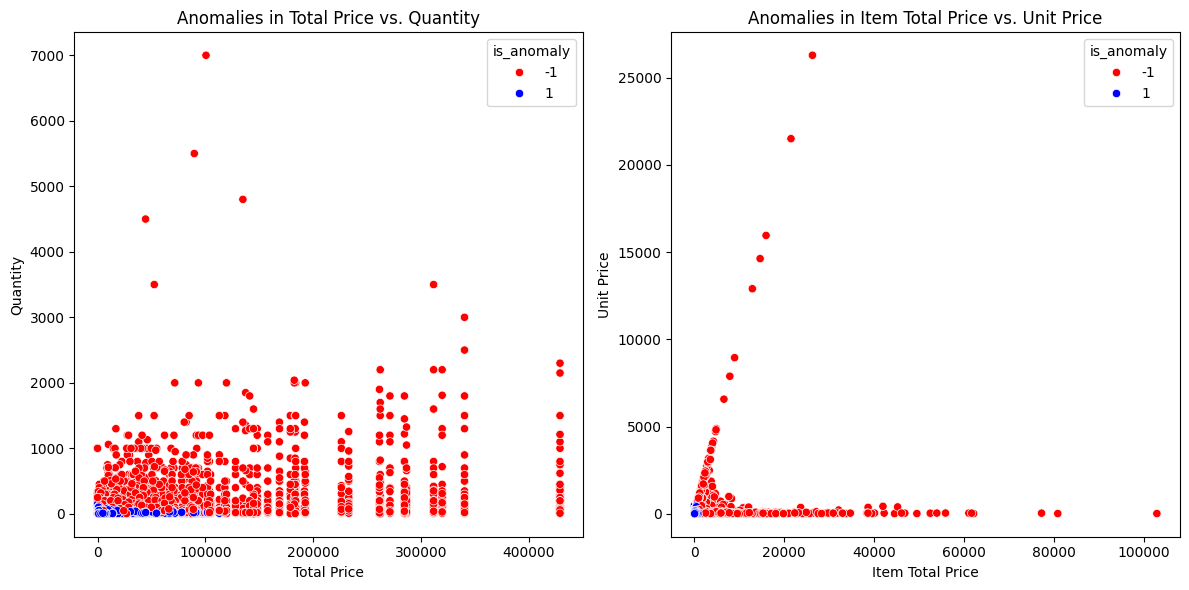

'\n# --- Alternative: Using DBSCAN for Anomaly Detection ---\nfrom sklearn.cluster import DBSCAN\n\n# Apply DBSCAN\n# Adjust \'eps\' (maximum distance between two samples for one to be considered as in the neighborhood of the other)\n# and \'min_samples\' (number of samples in a neighborhood for a point to be considered as a core point)\ndbscan = DBSCAN(eps=0.5, min_samples=5)\ndbscan_labels = dbscan.fit_predict(df_anomaly_scaled)\n\ndf_anomaly[\'dbscan_label\'] = dbscan_labels\n\nprint("\nDBSCAN Anomaly Analysis:")\nprint(df_anomaly[\'dbscan_label\'].value_counts())  # -1 indicates noise (potential anomalies)\n\n# Visualize DBSCAN results (for a pair of features)\nplt.figure(figsize=(8, 6))\nsns.scatterplot(x=\'total_price\', y=\'quantity\', data=df_anomaly, hue=\'dbscan_label\', palette=\'viridis\')\nplt.title(\'Anomalies detected by DBSCAN (Total Price vs. Quantity)\')\nplt.xlabel(\'Total Price\')\nplt.ylabel(\'Quantity\')\nplt.show()\n'

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

CONTAMINATION = 0.03

df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")

# Select the features for anomaly detection in transactions
anomaly_features = ['total_price', 'quantity', 'item_total_price', 'unit_price']
df = df.dropna()
df_anomaly = df[anomaly_features].copy()

# Scale the features using StandardScaler
scaler = MinMaxScaler()
df_anomaly_scaled = scaler.fit_transform(df_anomaly)

# Apply Isolation Forest for anomaly detection
# Adjust 'contamination' parameter based on the expected percentage of anomalies in your data
# 'random_state' ensures reproducibility
model = IsolationForest(contamination=CONTAMINATION, random_state=42,n_estimators=100)
model.fit(df_anomaly_scaled)

# Get anomaly scores and predictions
anomaly_scores = model.decision_function(df_anomaly_scaled)
anomaly_predictions = model.predict(df_anomaly_scaled)

# Add anomaly scores and predictions back to the original DataFrame
df_anomaly['anomaly_score'] = anomaly_scores
df_anomaly['is_anomaly'] = anomaly_predictions  # 1 for inlier, -1 for outlier

# Analyze the anomalies
print("\nAnomaly Statistics:")
print(df_anomaly['is_anomaly'].value_counts())

# Display some of the identified anomalies
anomalies = df_anomaly[df_anomaly['is_anomaly'] == -1]
print("\nIdentified Anomalies:")
print(anomalies.head())

# Visualize anomalies (for pairs of features)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='total_price', y='quantity', data=df_anomaly, hue='is_anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Total Price vs. Quantity')
plt.xlabel('Total Price')
plt.ylabel('Quantity')

plt.subplot(1, 2, 2)
sns.scatterplot(x='item_total_price', y='unit_price', data=df_anomaly, hue='is_anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Item Total Price vs. Unit Price')
plt.xlabel('Item Total Price')
plt.ylabel('Unit Price')

plt.tight_layout()
plt.show()

"""
# --- Alternative: Using DBSCAN for Anomaly Detection ---
from sklearn.cluster import DBSCAN

# Apply DBSCAN
# Adjust 'eps' (maximum distance between two samples for one to be considered as in the neighborhood of the other)
# and 'min_samples' (number of samples in a neighborhood for a point to be considered as a core point)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_anomaly_scaled)

df_anomaly['dbscan_label'] = dbscan_labels

print("\nDBSCAN Anomaly Analysis:")
print(df_anomaly['dbscan_label'].value_counts())  # -1 indicates noise (potential anomalies)

# Visualize DBSCAN results (for a pair of features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_price', y='quantity', data=df_anomaly, hue='dbscan_label', palette='viridis')
plt.title('Anomalies detected by DBSCAN (Total Price vs. Quantity)')
plt.xlabel('Total Price')
plt.ylabel('Quantity')
plt.show()
"""

In [ ]:
df_anomaly['is_churn'] = df['is_churn']

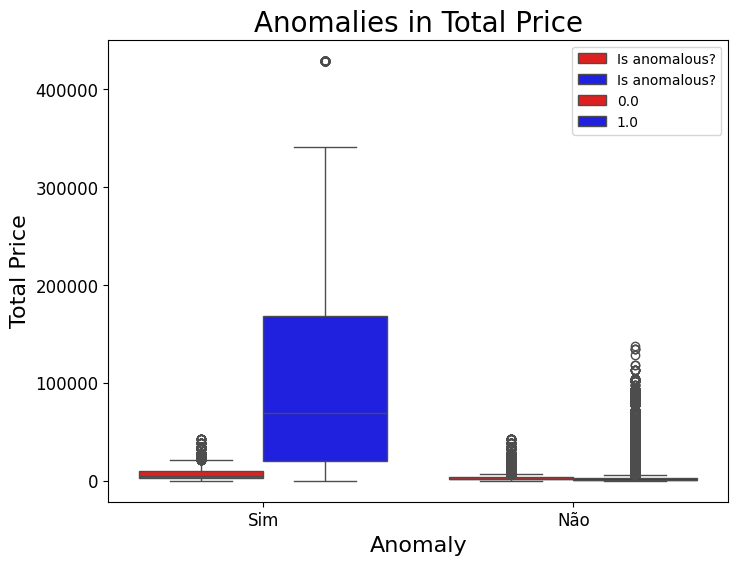

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_anomaly,y='total_price',x='is_anomaly',hue='is_churn',palette=['red','blue'],label='Is anomalous?',)

plt.title('Anomalies in Total Price',size=20)
plt.legend()
plt.xlabel('Anomaly',size=16)
plt.ylabel('Total Price',size=16)

plt.title('Anomalies in Total Price',size=20)
plt.xlabel('Anomaly',size=16)
plt.ylabel('Total Price',size=16)
plt.xticks([0,1],['Sim','Não'],size=12)
plt.yticks(size=12)



plt.show()

- Analysis of the Results:
1. Anomalies tend to have a much higher Total Price than non-anomaly, and if an anomaly is in fact a churn event, then this discrepancy is even much higher.

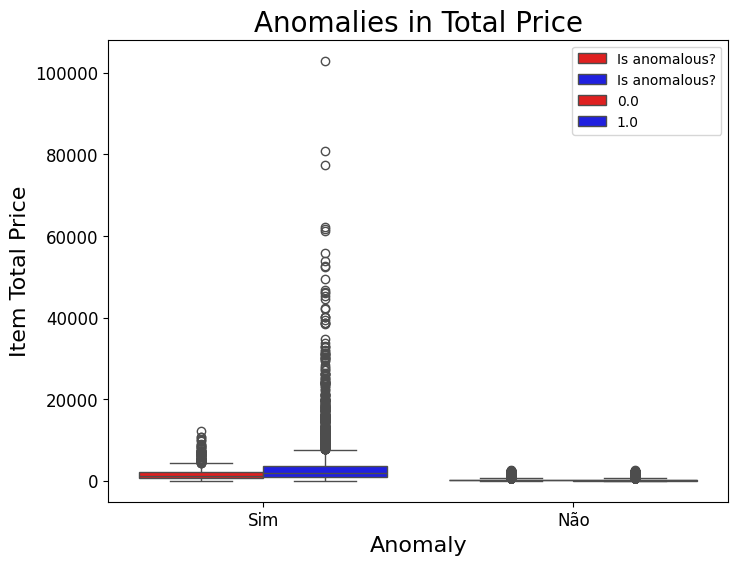

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_anomaly,y='item_total_price',x='is_anomaly',hue='is_churn',palette=['red','blue'],label='Is anomalous?',)

plt.title('Anomalies in Item Total Price',size=20)
plt.legend()

plt.title('Anomalies in Total Price',size=20)
plt.xlabel('Anomaly',size=16)
plt.ylabel('Item Total Price',size=16)
plt.xticks([0,1],['Sim','Não'],size=12)
plt.yticks(size=12)



plt.show()

- Analysis of the Results:
1. Anomalies tend to have a much higher Item Total Price than non-anomaly, and if an anomaly is in fact a churn event, then this discrepancy is even much higher.

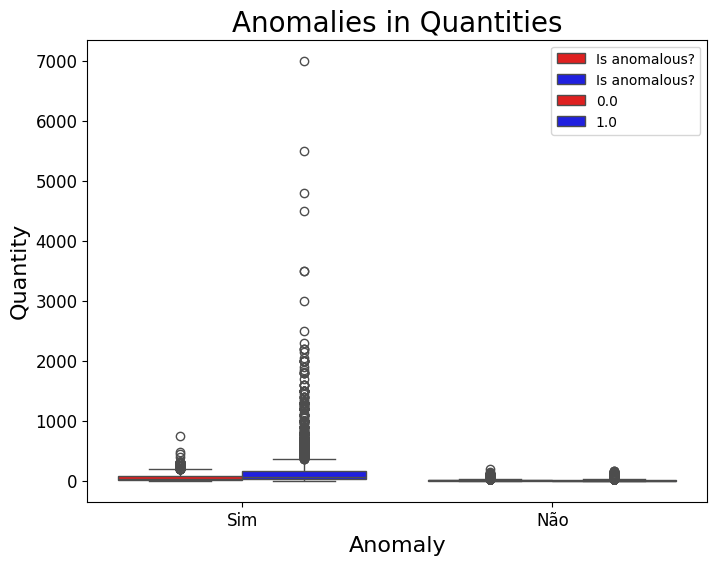

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_anomaly,y='quantity',x='is_anomaly',hue='is_churn',palette=['red','blue'],label='Is anomalous?',)

plt.title('Anomalies in Quantities',size=20)
plt.legend()

plt.xlabel('Anomaly',size=16)
plt.ylabel('Quantity',size=16)
plt.xticks([0,1],['Sim','Não'],size=12)
plt.yticks(size=12)

plt.show()

- Analysis of the Results:
1. Anomalies tend to have a much number of quantities ordered than non-anomaly, and if an anomaly is in fact a churn event, then this discrepancy is even much higher.

<ipython-input-7-b8f8d24d337c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_anomaly,x='is_churn',y='anomaly_score',palette=['red','blue'],label='Has Churned?',)


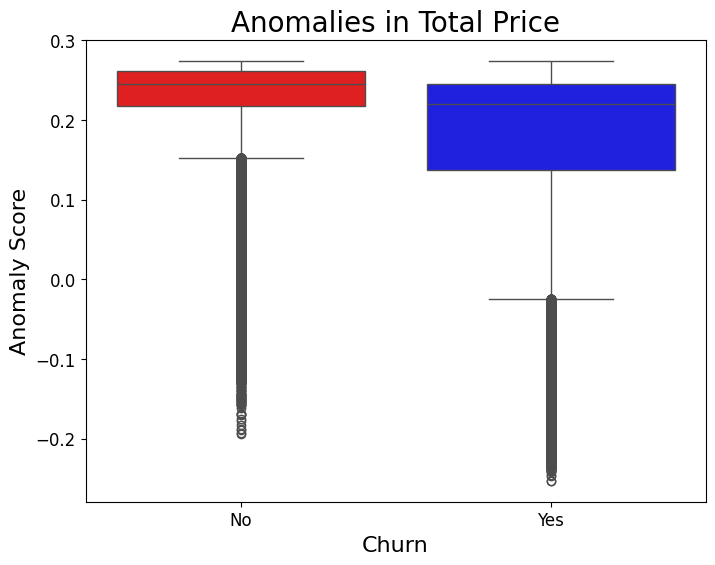

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_anomaly,x='is_churn',y='anomaly_score',palette=['red','blue'],label='Has Churned?',)

plt.title('Anomalies in Total Price',size=20)
plt.xlabel('Churn',size=16)
plt.ylabel('Anomaly Score',size=16)
plt.xticks([0,1],['No','Yes'],size=12)
plt.yticks(size=12)

plt.show()

- Analysis of the Results:
1. Churn events tend to have much higher Total Prices.

In [ ]:
df_anomaly.groupby('is_anomaly')['is_churn'].value_counts(normalize=True)*100

is_anomaly  is_churn
-1          1.0         72.136274
            0.0         27.863726
 1          0.0         82.523150
            1.0         17.476850
Name: proportion, dtype: float64

Analysis of the Results:
1. 72% of the anomaly events are churn events;
2. 82% of the non-anomaly events are non-churn events.

This point out that anomaly detection algorithms can be used to predict whether a customer will churn, or not.

In [ ]:
# Summary of the descriptive statistics, showing the differences between anomaly and normal events, as well, discriminating by churn and non-churn events.
df_anomaly.groupby(by=['is_anomaly','is_churn']).describe().T

is_anomaly                        -1                             1  \
is_churn                         0.0            1.0            0.0   
total_price      count   1693.000000    4383.000000  162106.000000   
                 mean    7935.637478  102326.969685    2961.300282   
                 std     8006.475291  100966.728060    2889.913201   
                 min       13.600000       8.320000       0.010000   
                 25%     2545.460000   20194.000000    1325.620000   
                 50%     5200.420000   69151.350000    2129.040000   
                 75%     9949.420000  168713.600000    3551.850000   
                 max    42222.800000  428976.460000   42222.800000   
quantity         count   1693.000000    4383.000000  162106.000000   
                 mean      52.272298     163.526580       8.596480   
                 std       68.015163     319.094149       9.220515   
                 min        1.000000       1.000000       1.000000   
                 25%        5.000000      25.000000       3.000000   
                 50%       24.000000      70.000000       6.000000   
                 75%       80.000000     160.000000      12.000000   
                 max      750.000000    7000.000000     203.000000   
item_total_price count   1693.000000    4383.000000  162106.000000   
                 mean    1664.543757    3533.012133     223.889072   
                 std     1417.680397    5728.055542     225.587542   
                 min       13.600000       2.000000       0.000000   
                 25%      681.870000    1022.400000      84.390000   
                 50%     1279.570000    1849.900000     156.300000   
                 75%     2158.200000    3669.925000     278.987500   
                 max    12067.650000  102951.110000    2523.600000   
unit_price       count   1693.000000    4383.000000  162106.000000   
                 mean     401.339905     173.207064      39.857603   
                 std      404.476602     850.555155      49.351477   
                 min        0.060000       0.010000       0.010000   
                 25%       39.810000      13.875000      15.110000   
                 50%      372.000000      27.970000      21.530000   
                 75%      613.600000      70.530000      45.080000   
                 max     4876.800000   26280.000000     563.200000   
anomaly_score    count   1693.000000    4383.000000  162106.000000   
                 mean      -0.046755      -0.097789       0.230927   
                 std        0.039968       0.063415       0.046252   
                 min       -0.194088      -0.253013       0.000010   
                 25%       -0.074250      -0.146342       0.218711   
                 50%       -0.034302      -0.091230       0.246403   
                 75%       -0.013225      -0.044169       0.261323   
                 max       -0.000007      -0.000006       0.274579   

is_anomaly                             
is_churn                          1.0  
total_price      count   34331.000000  
                 mean     4176.456632  
                 std     10950.149674  
                 min         0.010000  
                 25%       604.160000  
                 50%      1129.530000  
                 75%      2518.565000  
                 max    137367.600000  
quantity         count   34331.000000  
                 mean        8.826017  
                 std        14.077771  
                 min         1.000000  
                 25%         1.000000  
                 50%         4.000000  
                 75%        10.000000  
                 max       170.000000  
item_total_price count   34331.000000  
                 mean      205.233682  
                 std       259.023564  
                 min         0.010000  
                 25%        43.290000  
                 50%       116.500000  
                 75%       262.195000  
                 max      2532.780000  
unit_price       co

## Next Steps (**but DBSCAN IS TOO MUCH TIME CONSUMING**):

- Experiment with the contamination parameter in Isolation Forest and the **eps** and **min_samples** parameters in DBSCAN. These are critical for the performance of these algorithms. You might need to use techniques like visual inspection of the results or more formal evaluation metrics (if you have some ground truth about anomalies) to tune these parameters.
- Analyze the characteristics of the identified anomalies. Do they have exceptionally high or low total_price, quantity, or unit_price? Are there any patterns in these anomalous transactions (e.g., occurring at specific times, involving specific items)?
- Investigate the potential reasons for these anomalies. They could be due to data entry errors, fraudulent activities, unusual promotions, or genuine but rare customer behavior.
- Consider combining the results of different anomaly detection techniques for a more robust identification of anomalies.

## **Approach 5: Hierarchical Clustering**

### Hierarchical clustering is a versatile unsupervised learning technique that can definitely be applied to gain insights into your churn problem, even without directly predicting the "is_churn" label. Here's how you could use it, considering the available features:

#### **Use Cases for Hierarchical Clustering in a Churn Problem**:

##### Customer Segmentation Based on Similarity:

- **Features to Use**: use the same sets of features for K-Means segmentation (transaction behavior, registration/channel information, etc.).
- **How it works**: Hierarchical clustering builds a hierarchy of clusters, either by starting with each data point as its own cluster and iteratively merging the closest clusters (agglomerative) or by starting with one big cluster and recursively splitting it (divisive).

##### Potential Insights:

- **Discover natural groupings**: Hierarchical clustering doesn't require you to pre-specify the number of clusters. **The dendrogram it produces can help you visualize the relationships between data points and identify natural groupings at different levels of granularity.**
- **Understand cluster relationships**: The dendrogram shows which clusters are more similar to each other, providing a richer understanding of the customer segments and their relationships.
- **Identify potential churn-prone segments**: **After forming clusters, you can analyze the churn rate within each cluster** (by merging the cluster labels with "is_churn" column). This can reveal if certain segments, defined by their transaction history or registration details, have a higher propensity to churn.


### Analyzing by Customer

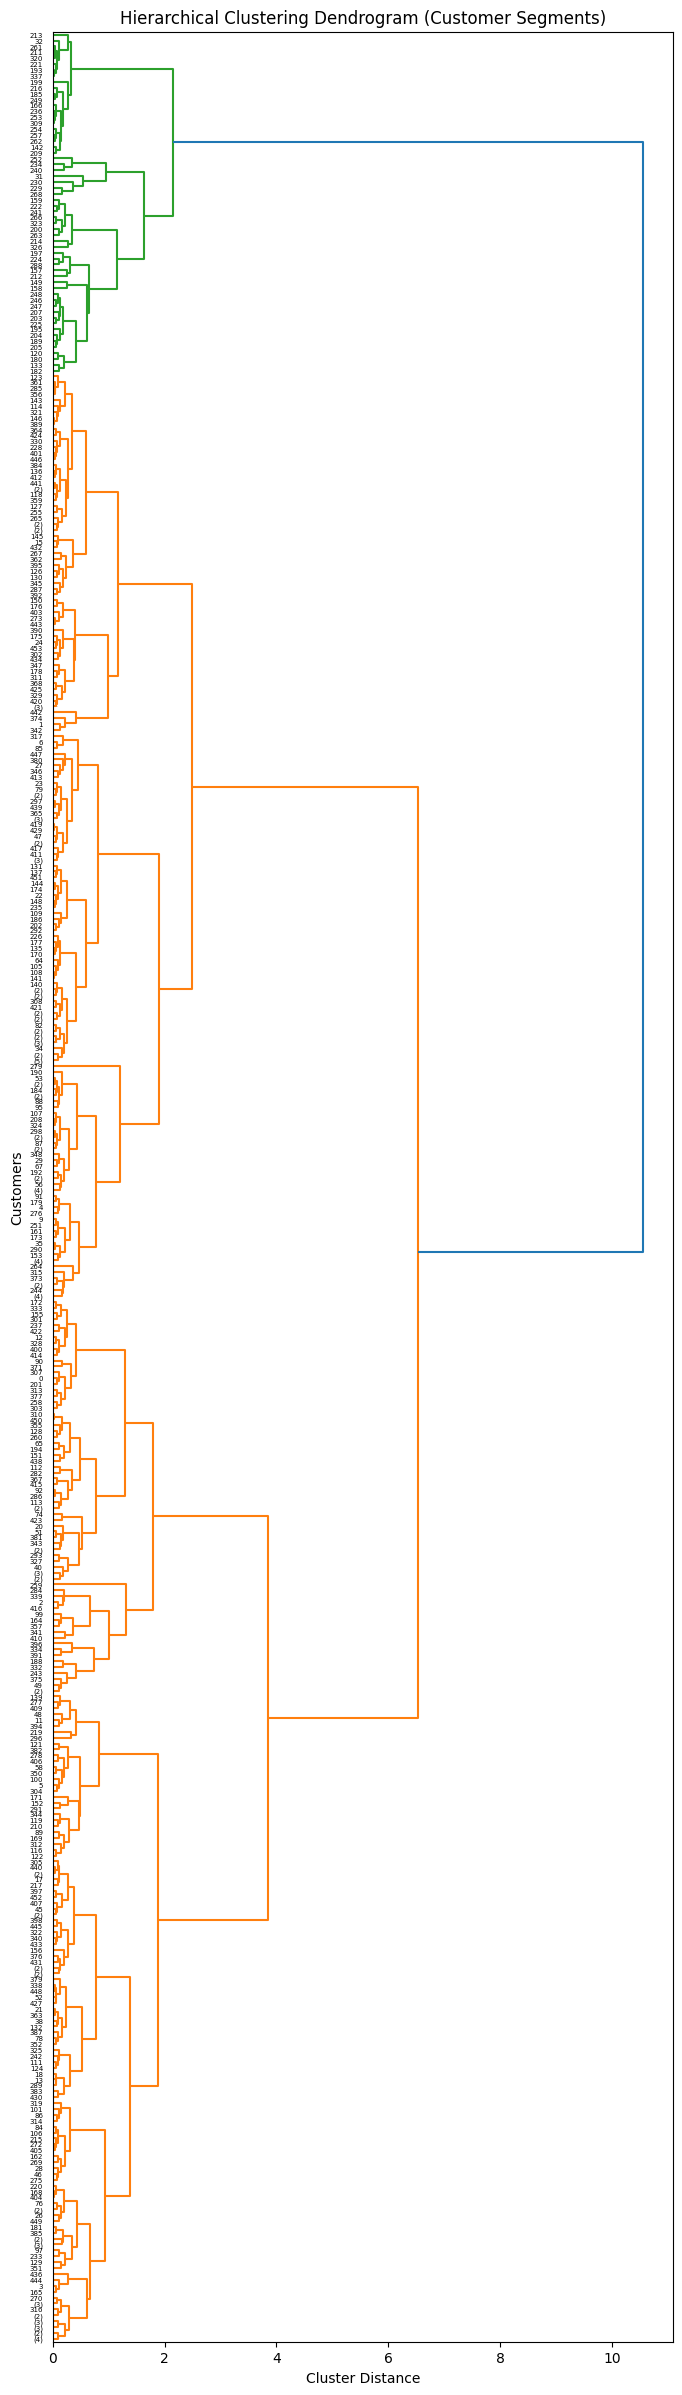


Hierarchical Cluster Analysis (Mean Feature Values):
                        total_spent  total_quantity  unique_items  \
hierarchical_cluster                                                
0                      97755.573308      476.715385     25.546154   
1                     306675.196027     1960.082192     45.780822   
2                     255342.968527      907.844961     47.201550   
3                     167336.530541      446.837838     37.378378   
4                     146698.248485     1119.318182     31.060606   
5                      28545.903810      160.333333     12.190476   

                      unique_groups  unique_segments  order_count  \
hierarchical_cluster                                                
0                               1.0              1.0     8.884615   
1                               1.0              1.0    30.397260   
2                               1.0              1.0    13.720930   
3                               1.0             

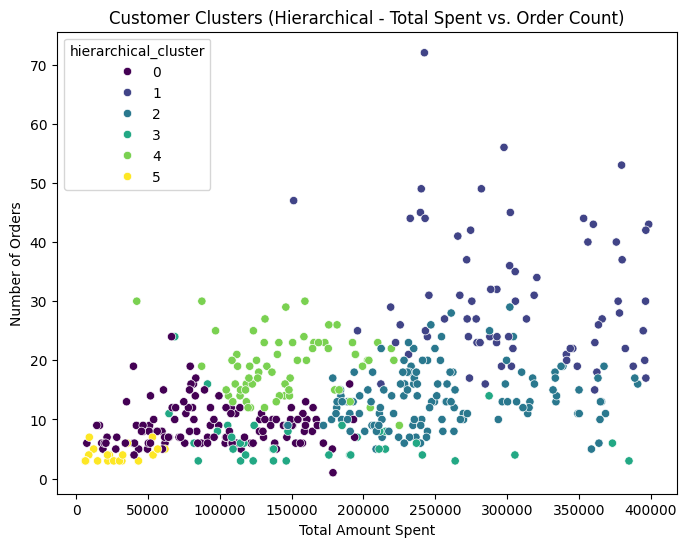

<ipython-input-42-d289b904f568>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_features, y='total_spent', x='hierarchical_cluster', palette='viridis')


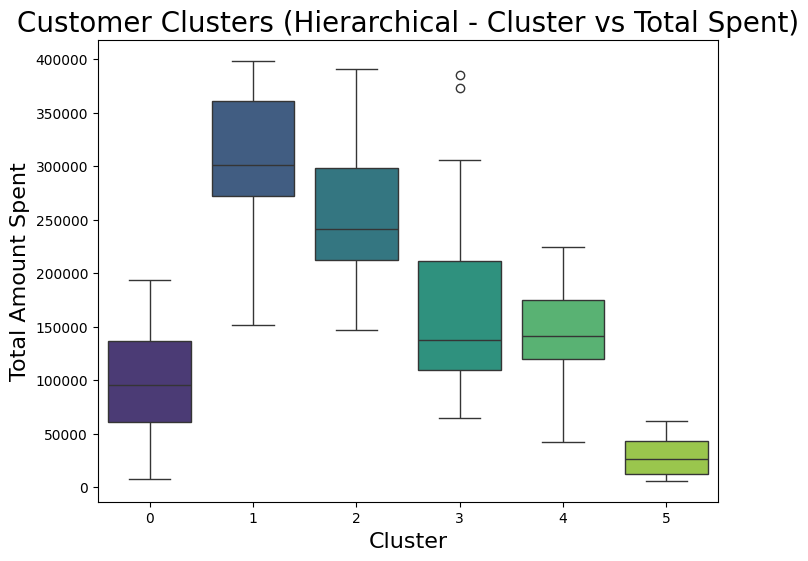

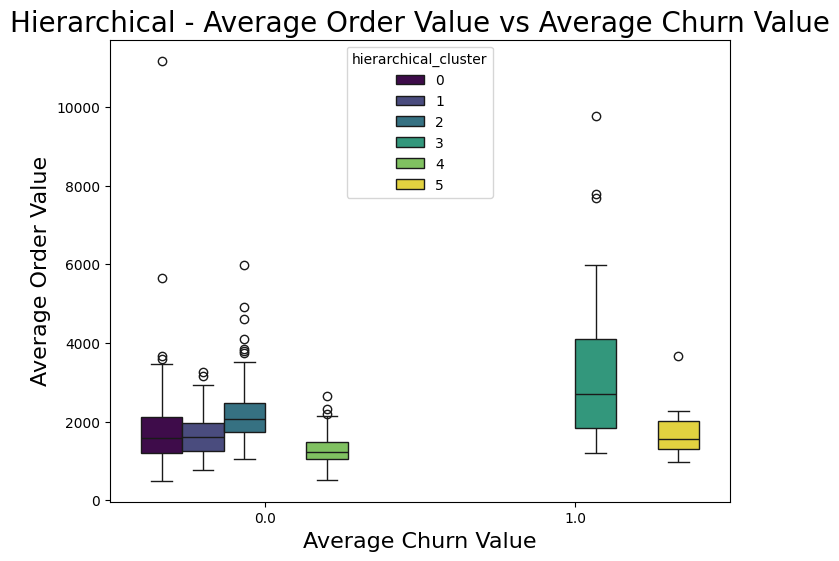

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")
df = df.dropna()


# --- Customer Segmentation using Hierarchical Clustering ---
# Select features (same as K-Means example for comparison)
customer_features = df.groupby('customer_code').agg(
    total_spent=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    unique_items=('item_code', 'nunique'),
    unique_groups=('group_code', lambda x: x.nunique()),
    unique_segments=('segment_code', lambda x: x.nunique()),
    order_count=('order_id', 'nunique'),
    avg_order_value=('total_price', 'mean'),
    avg_churn_value=('is_churn', 'mean')
).reset_index()

clustering_features = ['total_spent', 'total_quantity', 'unique_items', 'unique_groups',
                       'unique_segments', 'order_count', 'avg_order_value','avg_churn_value']
X = customer_features[clustering_features].copy()

# removing outliers
X = X[X['total_spent']<4*10**5]
customer_features = customer_features[customer_features['total_spent']<4*10**5]
X = X[X['order_count']<1*10**3]
customer_features = customer_features[customer_features['order_count']<1*10**3]

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply Agglomerative Hierarchical Clustering
# 'ward' linkage minimizes the variance within each cluster
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(8, 30))
dendrogram(linked,
           truncate_mode='level',
           p=10,
           show_leaf_counts=True,  # Show the number of data points in each leaf
           show_contracted=True,  # To indicate that subtrees have been cut
           orientation='right',
           distance_sort='descending',
           )
plt.title('Hierarchical Clustering Dendrogram (Customer Segments)')
plt.ylabel('Customers')
plt.xlabel('Cluster Distance')
plt.show()

# Determine the number of clusters by observing the dendrogram
# You look for the largest vertical distance without crossing any horizontal line

# Based on the dendrogram, choose a number of clusters (e.g., n_clusters=3)
n_clusters = 6
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
customer_features['hierarchical_cluster'] = agg_clustering.fit_predict(X_scaled)

# Analyze the clusters
print("\nHierarchical Cluster Analysis (Mean Feature Values):")
print(customer_features.groupby('hierarchical_cluster')[clustering_features].mean())

print("\nHierarchical Cluster Sizes:")
print(customer_features['hierarchical_cluster'].value_counts())

# Visualize the clusters (for a pair of features)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_features, x='total_spent', y='order_count', hue='hierarchical_cluster', palette='viridis')
plt.title('Customer Clusters (Hierarchical - Total Spent vs. Order Count)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Orders')
plt.show()


# Visualize the clusters (for a pair of features)
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_features, y='total_spent', x='hierarchical_cluster', palette='viridis')
plt.title('Customer Clusters (Hierarchical - Cluster vs Total Spent)',size=20)
plt.ylabel('Total Amount Spent',size=16)
plt.xlabel('Cluster',size=16)
plt.show()

# Visualize the clusters (for a pair of features)
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_features, y='avg_order_value', hue='hierarchical_cluster', x='avg_churn_value',palette='viridis')
plt.title('Hierarchical - Average Order Value vs Average Churn Value',size=20)
plt.ylabel('Average Order Value',size=16)
plt.xlabel('Average Churn Value',size=16)
plt.show()



# --- Item Grouping using Hierarchical Clustering (Conceptual Code) ---
# (You would need to prepare the data in a similar way to the co-occurrence matrix example)
# item_co_occurrence_scaled = scaler.fit_transform(item_co_occurrence) # Scale if needed
# linked_items = linkage(item_co_occurrence_scaled, method='ward')
# plt.figure(figsize=(15, 10))
# dendrogram(linked_items,
#             orientation='top',
#             labels=unique_items, # If you have item names
#             show_leaf_counts=True)
# plt.title('Hierarchical Clustering Dendrogram (Items)')
# plt.xlabel('Items')
# plt.ylabel('Cluster Distance')
# plt.show()
#
# n_clusters_items_hierarchical = 5 # Choose based on the dendrogram
# agg_clustering_items = AgglomerativeClustering(n_clusters=n_clusters_items_hierarchical, linkage='ward')
# # Assign cluster labels to items

In [ ]:
mean_clusters = customer_features.groupby('hierarchical_cluster',as_index=False)[clustering_features].mean()
median_clusters = customer_features.groupby('hierarchical_cluster',as_index=False)[clustering_features].median()
std_clusters = customer_features.groupby('hierarchical_cluster',as_index=False)[clustering_features].std()

In [ ]:
print(mean_clusters)

   hierarchical_cluster    total_spent  total_quantity  unique_items  \
0                     0   97755.573308      476.715385     25.546154   
1                     1  306675.196027     1960.082192     45.780822   
2                     2  255342.968527      907.844961     47.201550   
3                     3  167336.530541      446.837838     37.378378   
4                     4  146698.248485     1119.318182     31.060606   
5                     5   28545.903810      160.333333     12.190476   

   unique_groups  unique_segments  order_count  avg_order_value  \
0            1.0              1.0     8.884615      1811.853080   
1            1.0              1.0    30.397260      1623.403040   
2            1.0              1.0    13.720930      2232.321913   
3            1.0              1.0     6.648649      3230.277025   
4            1.0              1.0    19.106061      1315.020618   
5            1.0              1.0     4.047619      1693.662700   

   avg_churn_value  
0   

In [ ]:
print(median_clusters)

   hierarchical_cluster  total_spent  total_quantity  unique_items  \
0                     0     95935.15           467.0          24.0   
1                     1    301033.26          1836.0          41.0   
2                     2    241113.25           905.0          45.0   
3                     3    137450.06           309.0          35.0   
4                     4    141288.16          1050.5          30.5   
5                     5     26122.17            94.0          11.0   

   unique_groups  unique_segments  order_count  avg_order_value  \
0            1.0              1.0          8.0      1572.997671   
1            1.0              1.0         27.0      1606.854167   
2            1.0              1.0         13.0      2072.841356   
3            1.0              1.0          6.0      2691.647465   
4            1.0              1.0         19.0      1221.990616   
5            1.0              1.0          4.0      1546.581250   

   avg_churn_value  
0              0.0

In [ ]:
std_clusters.columns = (col + '_std' if col!='hierarchical_cluster' else col for col in std_clusters.columns)
print(std_clusters)

   hierarchical_cluster  total_spent_std  total_quantity_std  \
0                     0     46496.302423          213.575549   
1                     1     58757.164284          495.984984   
2                     2     55820.965474          303.569119   
3                     3     80757.491541          348.525028   
4                     4     37431.590457          435.719887   
5                     5     17955.076434          175.682763   

   unique_items_std  unique_groups_std  unique_segments_std  order_count_std  \
0         12.558151                0.0                  0.0         3.461045   
1         23.290584                0.0                  0.0        11.147670   
2         17.831407                0.0                  0.0         4.948132   
3         19.109845                0.0                  0.0         4.211203   
4         10.390645                0.0                  0.0         4.977268   
5          7.698175                0.0                  0.0         1.3

In [ ]:
# merge mean_clusters, median_clusters, and std clusters
merged_statistics_clusters = mean_clusters.merge(median_clusters, on='hierarchical_cluster', suffixes=('_mean', '_median'))
merged_statistics_clusters = merged_statistics_clusters.merge(std_clusters, on='hierarchical_cluster',suffixes=('_median', '_std'))


In [ ]:
print(merged_statistics_clusters.columns)

Index(['hierarchical_cluster', 'total_spent_mean', 'total_quantity_mean',
       'unique_items_mean', 'unique_groups_mean', 'unique_segments_mean',
       'order_count_mean', 'avg_order_value_mean', 'avg_churn_value_mean',
       'total_spent_median', 'total_quantity_median', 'unique_items_median',
       'unique_groups_median', 'unique_segments_median', 'order_count_median',
       'avg_order_value_median', 'avg_churn_value_median', 'total_spent_std',
       'total_quantity_std', 'unique_items_std', 'unique_groups_std',
       'unique_segments_std', 'order_count_std', 'avg_order_value_std',
       'avg_churn_value_std'],
      dtype='object')


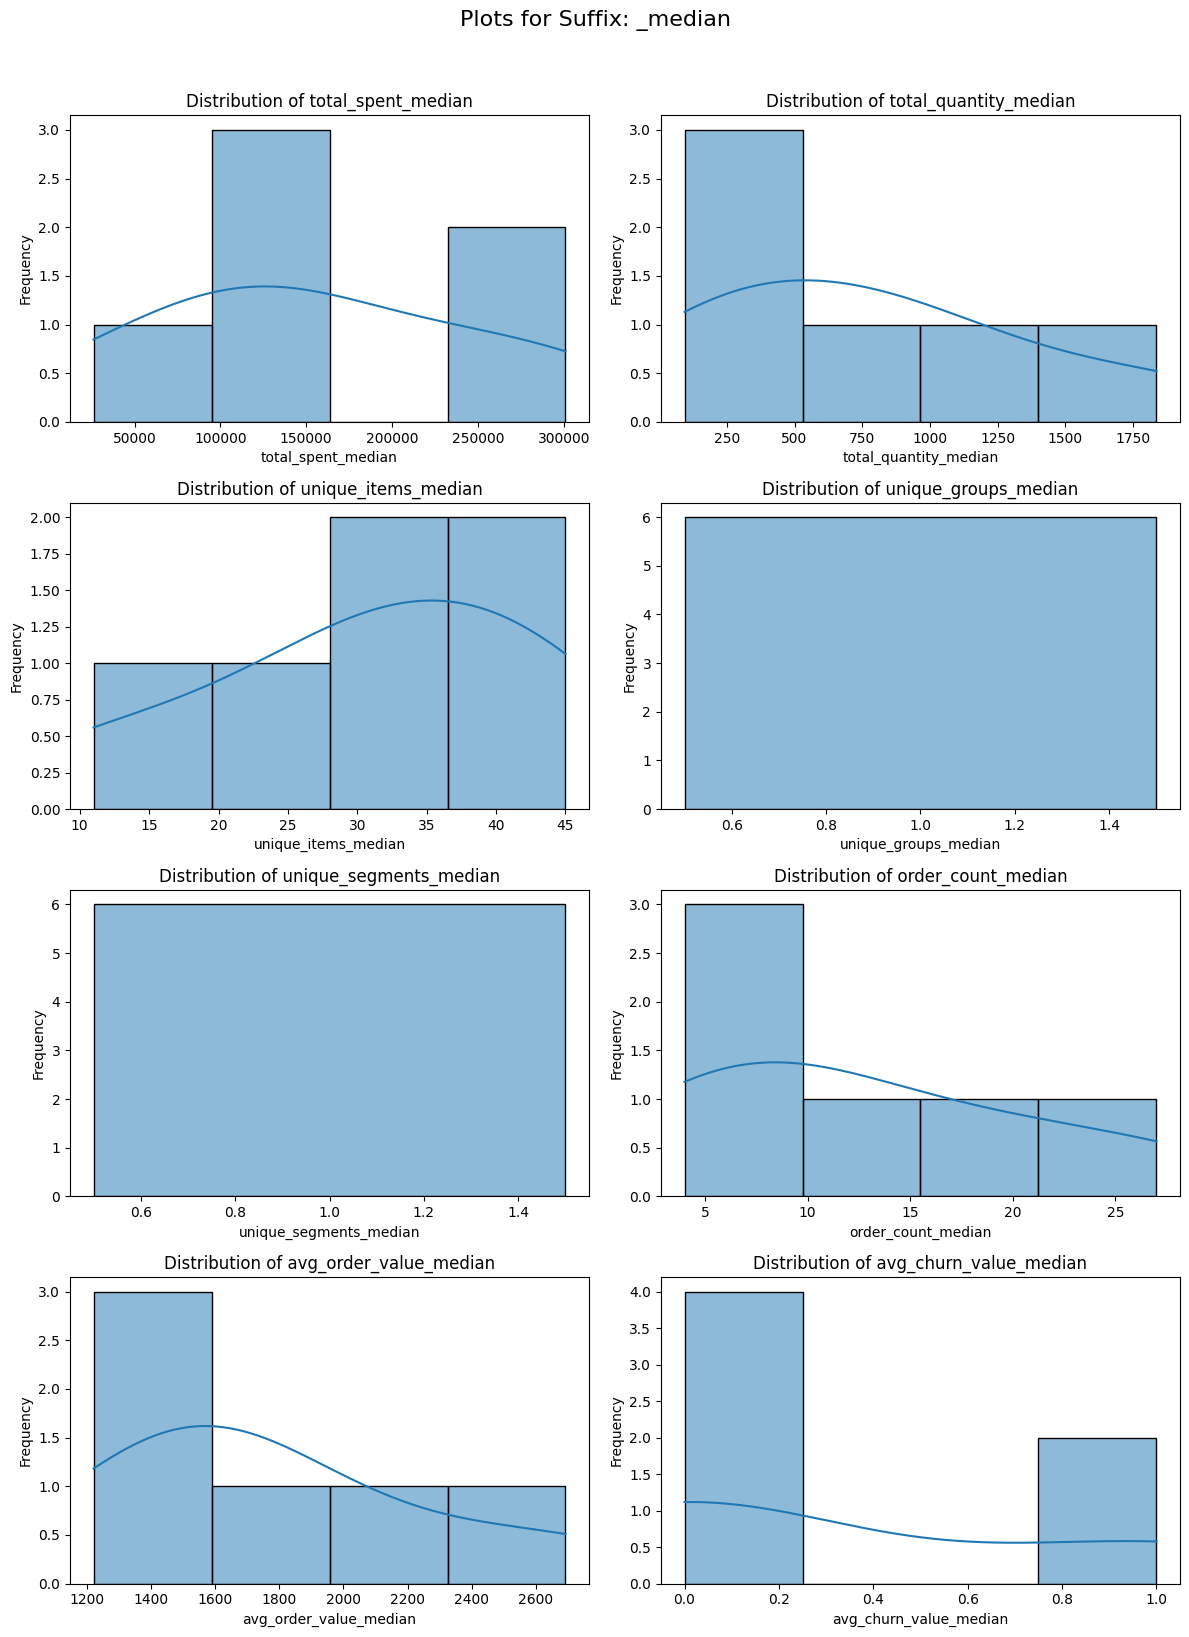

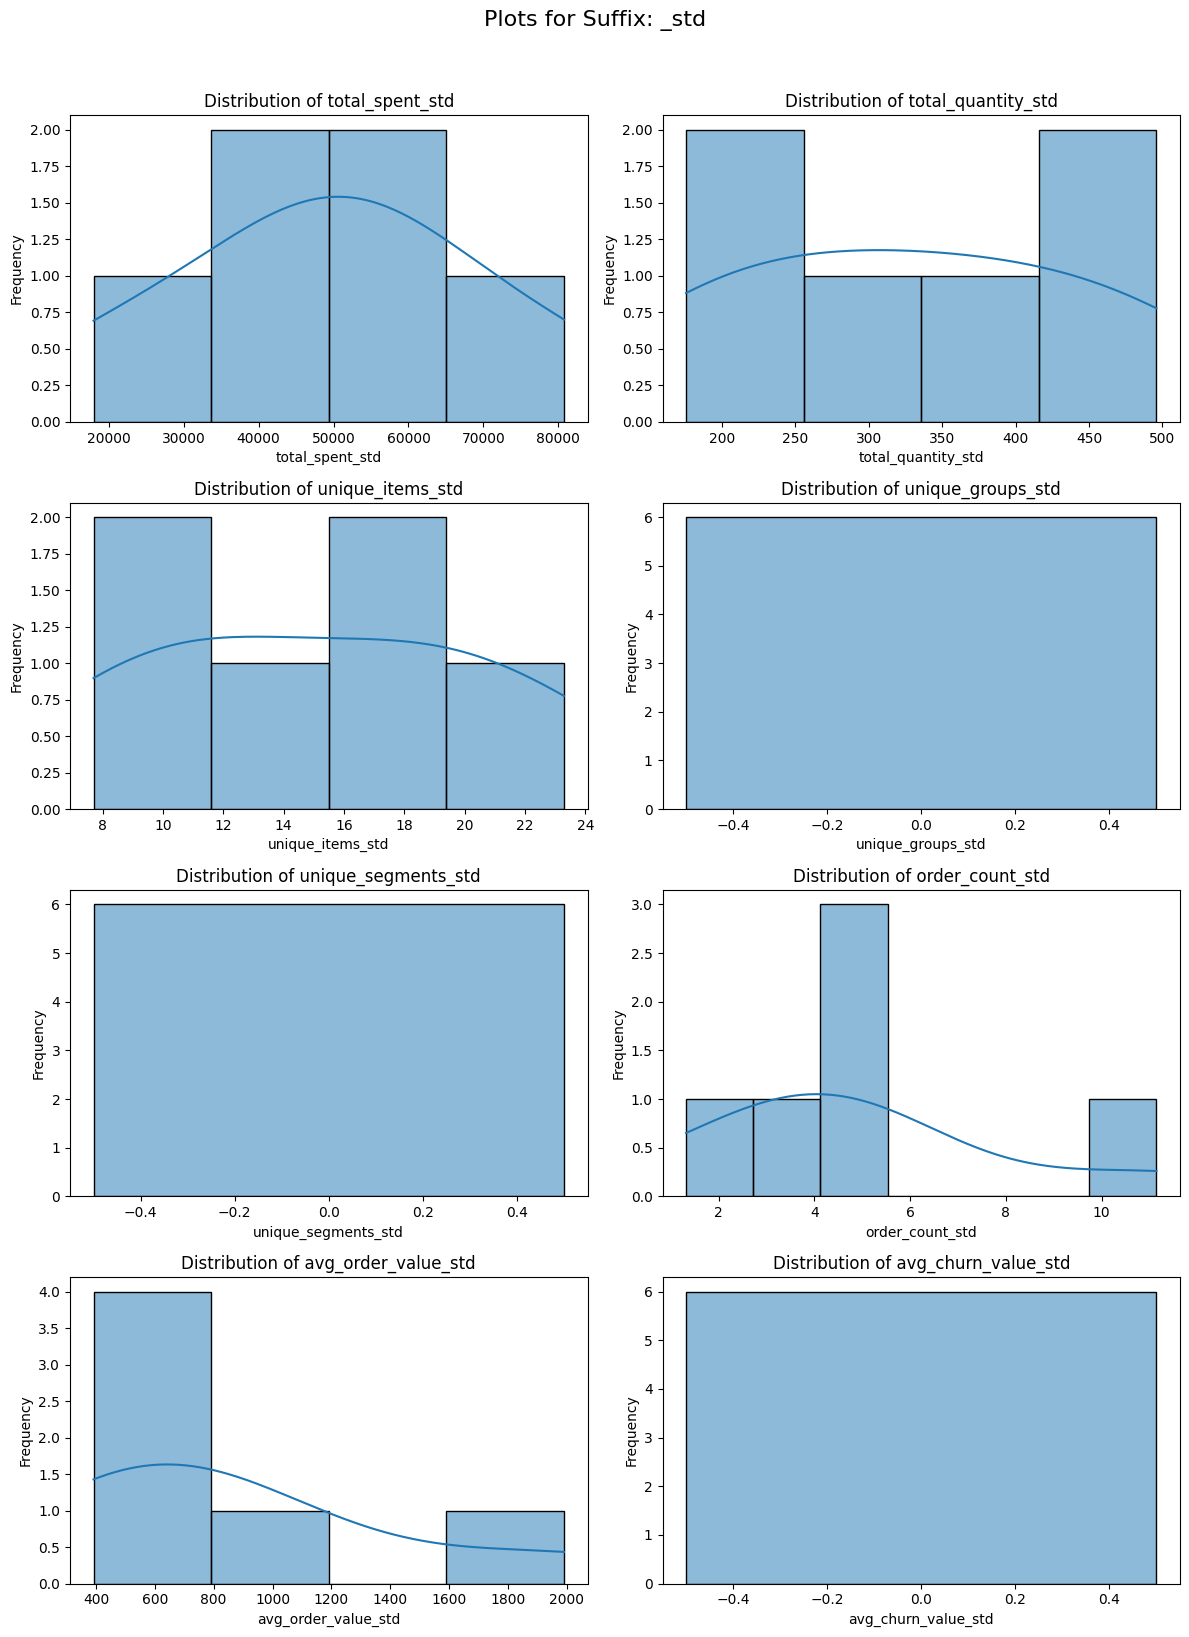

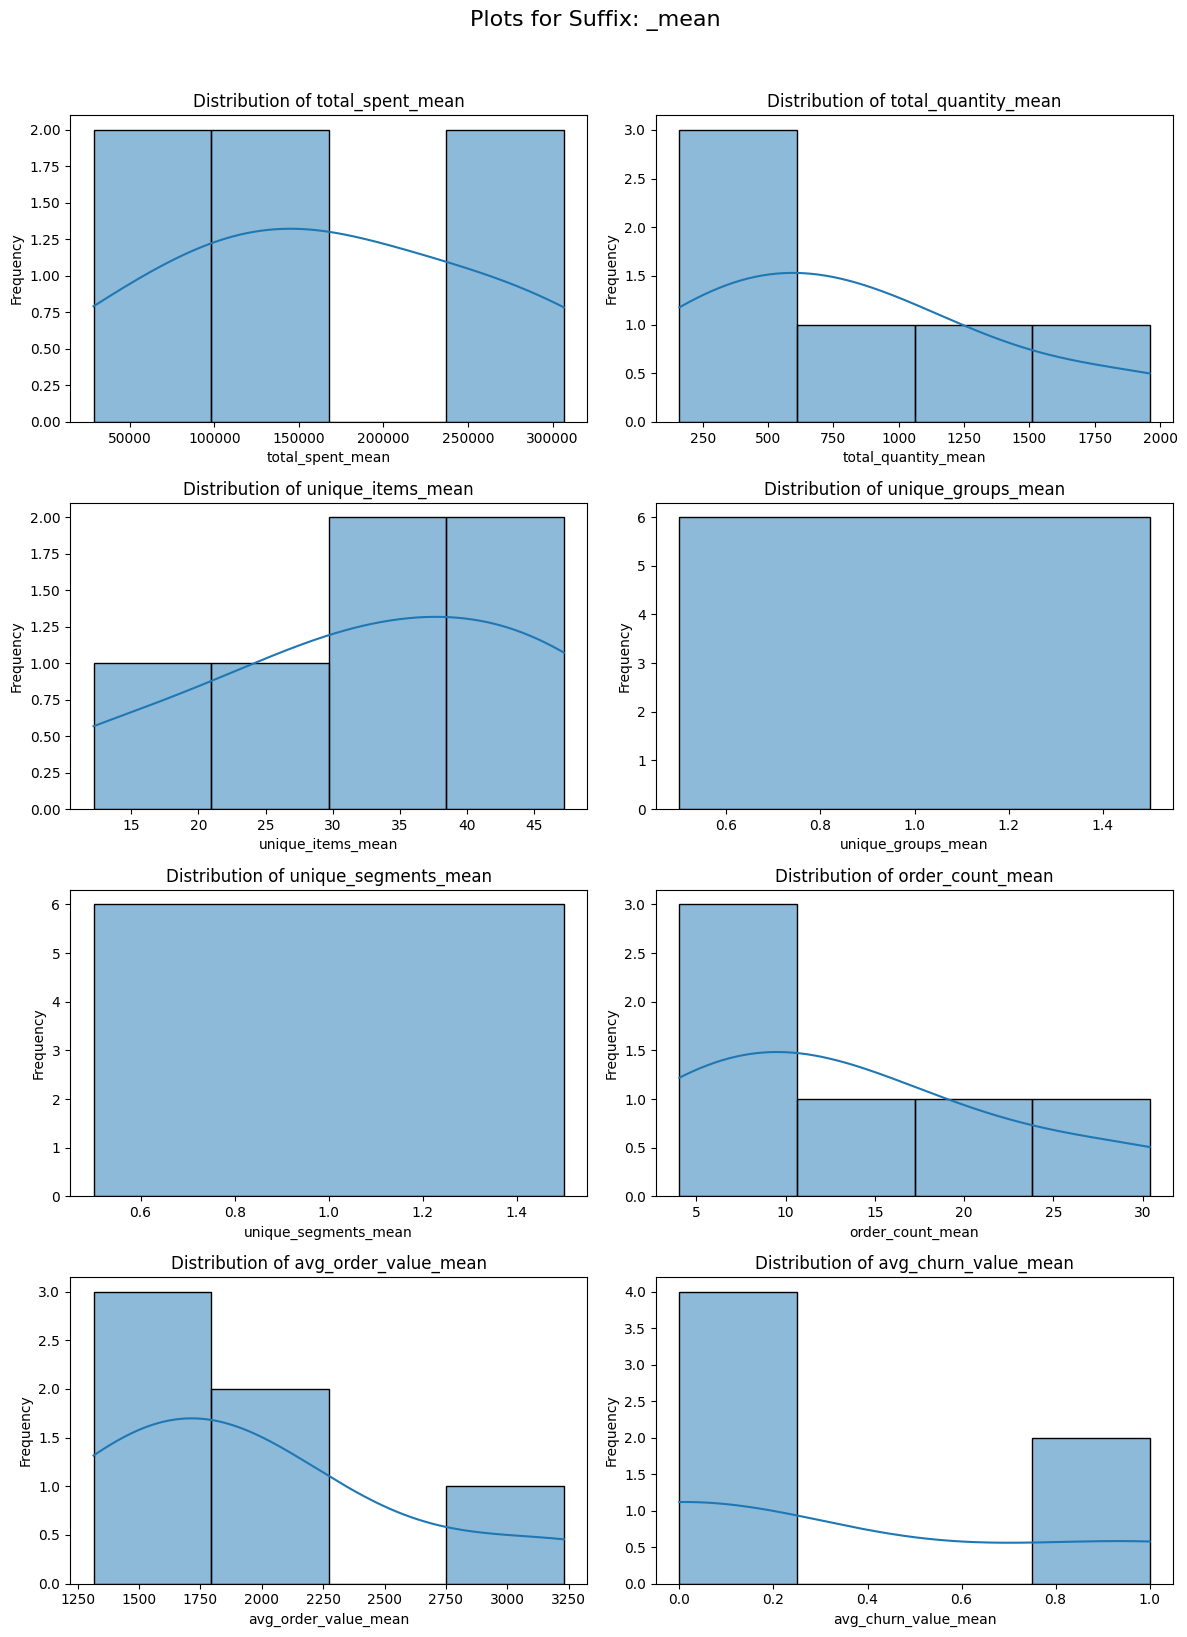

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is already loaded and preprocessed as 'df_segmentation'
# based on your provided code context.
# If not, you'll need to load and preprocess it first.

# Example: Let's assume df_segmentation has columns with suffixes like '_count', '_mean', etc.
# You'll need to adjust the code below to match the actual suffixes in your DataFrame.

# Find columns with suffixes you want to plot
columns_to_plot = [col for col in merged_statistics_clusters.columns if col.endswith(('_median', '_mean', '_std'))]

# Get the unique suffixes
suffixes = list(set([col.split('_')[-1] for col in columns_to_plot]))

# Iterate through each suffix and create a subplot for its related columns
for suffix in suffixes:
    # Get columns for the current suffix
    cols_with_suffix = [col for col in columns_to_plot if col.endswith('_' + suffix)]

    # Determine the number of plots for this suffix
    num_plots = len(cols_with_suffix)

    # Calculate the number of rows and columns for the subplot grid
    # You can adjust the grid size based on the number of plots
    n_cols = 2  # For example, 2 columns per row
    n_rows = (num_plots + n_cols - 1) // n_cols

    # Create the subplot figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    fig.suptitle(f'Plots for Suffix: _{suffix}', y=1.02, fontsize=16) # Add a title for the subplot

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through the columns with the current suffix and plot them in subplots
    for i, col in enumerate(cols_with_suffix):
        sns.histplot(data=merged_statistics_clusters, x=col, ax=axes[i], kde=True) # Example: histogram
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Remove any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Key Differences and Considerations for Hierarchical Clustering:

1. **Dendrogram**: The primary output of hierarchical clustering is a dendrogram, which is a tree-like diagram that shows the sequence of merges or splits and the distances between clusters. **Interpreting the dendrogram is crucial for deciding on the number of clusters. You look for the largest vertical gaps that are not crossed by horizontal lines.**

2. Number of Clusters: Unlike K-Means, you don't need to specify the number of clusters beforehand. You can choose the number after examining the dendrogram.

3. Linkage Methods: Hierarchical clustering offers different linkage methods (e.g., 'ward', 'average', 'complete', 'single') that define how the distance between clusters is calculated. **The 'ward' method is often a good default as it tries to minimize the variance within clusters.**

4.Computational Cost: Hierarchical clustering can be computationally more expensive than K-Means, especially for very large datasets.

- How to Use Hierarchical Clustering for Churn Insights:

1. Apply hierarchical clustering to your customer data using relevant features.
Examine the dendrogram to understand the relationships between customers and decide on a meaningful number of clusters.
2. Cut the dendrogram at the chosen number of clusters to assign cluster labels to each customer.
3. Analyze the characteristics of each cluster by looking at the mean values of the features within each cluster.
4. Merge the cluster labels back with your original DataFrame containing the is_churn column.
5. **Calculate the churn rate for each cluster. This can help you identify segments with higher or lower churn probabilities.**
6. **Develop targeted strategies based on the insights gained from these segments.**
7. Hierarchical clustering provides a valuable alternative to K-Means for exploring the underlying structure of your customer data and can offer a more nuanced understanding of customer segments and their potential relationship with churn. Remember to experiment with different features and linkage methods to find the most meaningful groupings.

## **Approach 6: PCA**

### How PCA Can Provide Insights for Churn:

- **Dimensionality Reduction**: PCA can reduce the number of features you need to consider, making subsequent analysis (like visualization or supervised learning) more manageable and potentially less prone to multicollinearity.
- **Feature Engineering**: The principal components themselves can be treated as new, engineered features that capture the most variance in your original data. These components might represent underlying customer behavior patterns (e.g., a component representing high spending and frequent purchases).
- **Identifying Key Drivers**: By examining the loadings, you can understand which original features have the strongest influence on each principal component. This can give you insights into the key dimensions along which your customers vary. For example:
- PC1 might be heavily influenced by total_spent and order_count, suggesting a "customer engagement and value" dimension.
- PC2 might be driven by unique_items, indicating a "product exploration" dimension.
- PC3 could be related to days_since_registration, representing "customer tenure."
- **Visualization**: You can visualize the customers in the space of the first few principal components (e.g., a scatter plot of PC1 vs. PC2), which might reveal natural groupings or segments of customers based on these underlying dimensions.
- **Input for Other Models**: The principal components can be used as input features for supervised churn prediction models. They might capture complex relationships in the data more effectively than the original features alone.


Explained Variance Ratio: [0.54229295 0.2571344  0.10882029 0.06464108 0.02449733 0.00261394]
Cumulative Explained Variance: [0.54229295 0.79942736 0.90824765 0.97288873 0.99738606 1.        ]


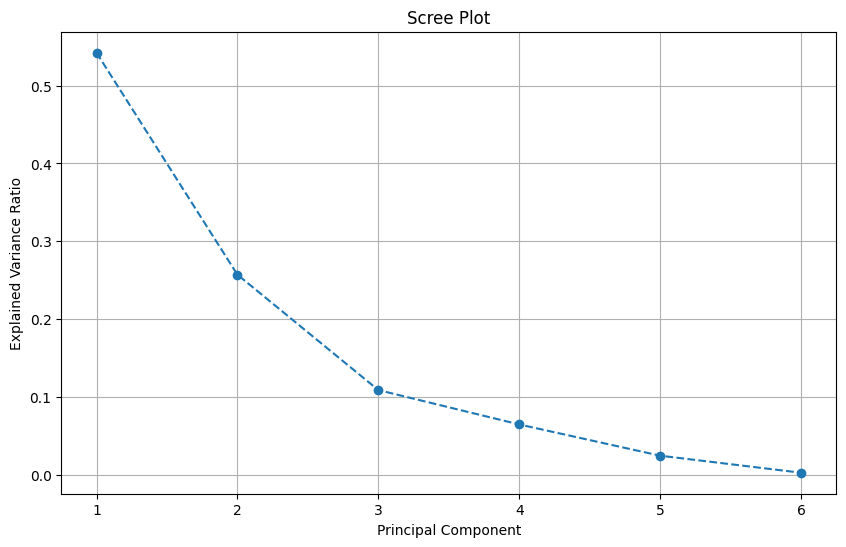

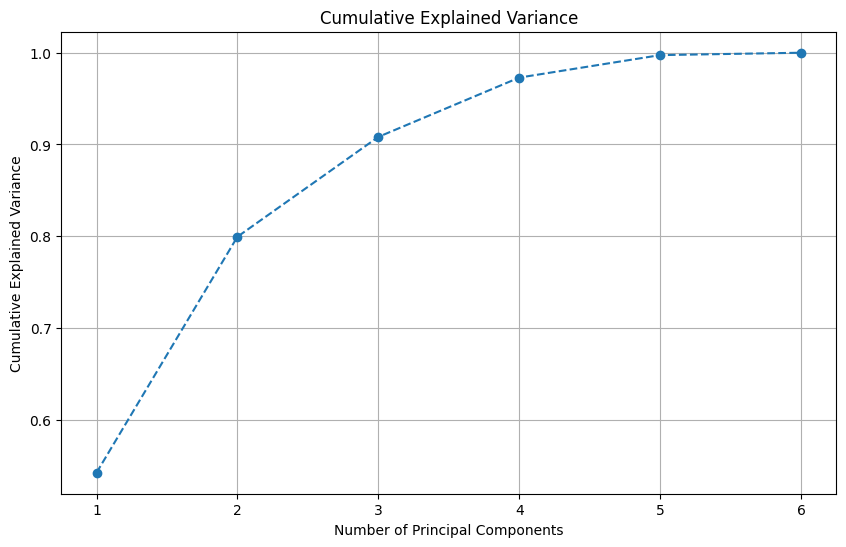


Principal Components DataFrame:
   customer_code  principal_component_1  principal_component_2  \
0              0               0.011137               0.038984   
1              1               0.010004              -0.003653   
2              2              -0.000845               0.007756   
3              3               0.270789               0.103740   
4              4               0.037138               0.008508   

   principal_component_3  principal_component_4  principal_component_5  \
0              -0.017624              -0.016500               0.001178   
1               0.008982               0.019121              -0.014710   
2              -0.023694               0.006401              -0.024010   
3              -0.000089               0.062950               0.017452   
4               0.025702              -0.005353               0.001481   

   principal_component_6  
0               0.003006  
1               0.002243  
2               0.002169  
3              -0

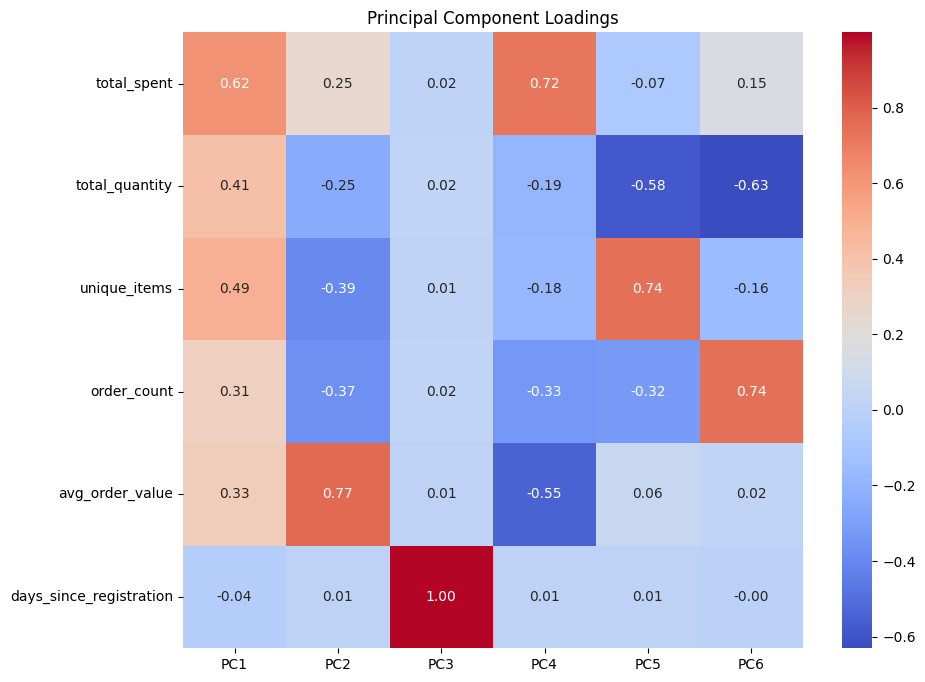

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")

df = df.dropna()

# Identify relevant numerical features for PCA
# Consider features related to transactions, spending, and potentially registration date
features_for_pca = ['total_price', 'quantity', 'item_total_price', 'unit_price',
                    # Aggregate features per customer (as done for clustering) might be more insightful
                    # Let's create a customer-level DataFrame for PCA
                    ]

customer_features_pca = df.groupby('customer_code').agg(
    total_spent=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    unique_items=('item_code', 'nunique'),
    order_count=('order_id', 'nunique'),
    avg_churn = ('is_churn', 'mean'),
    avg_order_value=('total_price', 'mean'),
    days_since_registration=('register_date', lambda x: (pd.to_datetime('now').tz_localize(None) - pd.to_datetime(x.max()).tz_localize(None)).days if not x.empty else 0)
).reset_index()

# Select the features for PCA
pca_features = ['total_spent', 'total_quantity', 'unique_items', 'order_count', 'avg_order_value', 'days_since_registration']
X = customer_features_pca[pca_features].copy().dropna()

# removing outliers
# removing outliers
X = X[X['total_spent']<1*10**8]
customer_features_pca = customer_features_pca[customer_features_pca['total_spent']<1*10**8]
#X = X[X['order_count']<1*10**3]
#customer_features_pca = customer_features_pca[customer_features_pca['order_count']<1*10**3]


# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
# You can specify the number of components you want to keep, or let it determine based on explained variance
pca = PCA()
pca.fit(X_scaled)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Scree Plot to determine the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components based on the scree plot or explained variance
n_components = 6  # Example: Keeping 6 components

pca_final = PCA(n_components=n_components)
principal_components = pca_final.fit_transform(X_scaled)

# Create a DataFrame of the principal components
pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'principal_component_{i+1}' for i in range(n_components)])

# Merge with customer information (optional)
pca_df = pd.concat([customer_features_pca[['customer_code']].reset_index(drop=True), pca_df], axis=1)

print("\nPrincipal Components DataFrame:")
print(pca_df.head())

# Loadings (to understand which original features contribute most to each component)
loadings = pd.DataFrame(pca_final.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=pca_features)
print("\nLoadings:")
print(loadings)

# Visualize the loadings (optional)
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Principal Component Loadings')
plt.show()

In [ ]:
pca_df.head()

,customer_code,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6
0,0,0.011137,0.038984,-0.017624,-0.016500,0.001178,0.003006
1,1,0.010004,-0.003653,0.008982,0.019121,-0.014710,0.002243
2,2,-0.000845,0.007756,-0.023694,0.006401,-0.024010,0.002169
3,3,0.270789,0.103740,-0.000089,0.062950,0.017452,-0.009768
4,4,0.037138,0.008508,0.025702,-0.005353,0.001481,-0.008039


In [ ]:
pca_df

,customer_code,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6
0,0,0.011137,0.038984,-0.017624,-0.016500,0.001178,0.003006
1,1,0.010004,-0.003653,0.008982,0.019121,-0.014710,0.002243
2,2,-0.000845,0.007756,-0.023694,0.006401,-0.024010,0.002169
3,3,0.270789,0.103740,-0.000089,0.062950,0.017452,-0.009768
4,4,0.037138,0.008508,0.025702,-0.005353,0.001481,-0.008039
...,...,...,...,...,...,...,...
812,832,0.001786,-0.013678,-0.000182,0.005915,0.011685,-0.001441
813,833,0.057245,0.058839,0.007310,0.004964,-0.011648,0.000739
814,835,-0.077148,-0.008644,0.517139,0.007014,-0.004334,0.000879
815,836,0.179400,-0.013506,-0.018730,0.042047,0.080403,0.004452


In [ ]:
df_pca_churn = customer_features_pca.merge(pca_df, on='customer_code')

In [ ]:
df_pca_churn.head()

,customer_code,total_spent,total_quantity,unique_items,order_count,avg_churn,avg_order_value,days_since_registration,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6
0,0,785677.26,1666,52,19,0.0,4389.258436,2536,0.011137,0.038984,-0.017624,-0.016500,0.001178,0.003006
1,1,1083620.64,3217,50,42,0.0,2300.680764,2624,0.010004,-0.003653,0.008982,0.019121,-0.014710,0.002243
2,2,841537.44,3204,30,39,0.0,2741.164300,2516,-0.000845,0.007756,-0.023694,0.006401,-0.024010,0.002169
3,3,5102786.19,10124,190,63,0.0,8035.883764,2567,0.270789,0.103740,-0.000089,0.062950,0.017452,-0.009768
4,4,1076850.86,4383,86,41,0.0,3577.577608,2677,0.037138,0.008508,0.025702,-0.005353,0.001481,-0.008039


In [ ]:
# create a column that represents the component that has the largest value
df_pca_churn['principal_component_max'] = df_pca_churn[['principal_component_1', 'principal_component_2', 'principal_component_3','principal_component_4', 'principal_component_5', 'principal_component_6']].idxmax(axis=1)

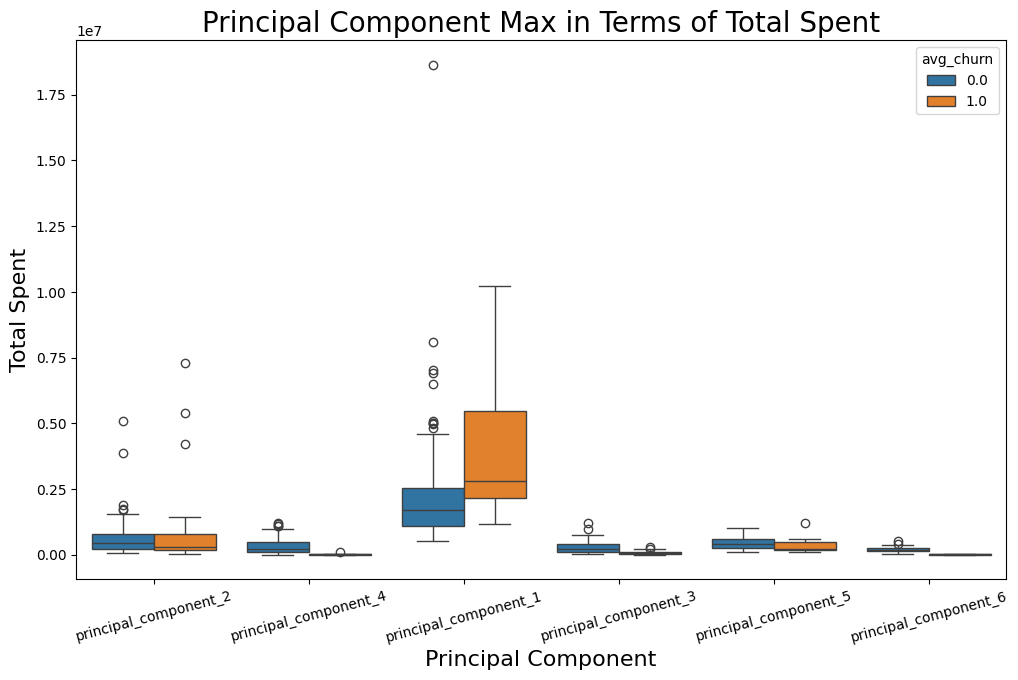

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(12, 7))

sns.boxplot(data=df_pca_churn, x='principal_component_max', y='total_spent',
            hue='avg_churn')
plt.title('Principal Component Max in Terms of Total Spent',size=20)
plt.xlabel('Principal Component',size=16)
plt.ylabel('Total Spent',size=16)
plt.xticks(rotation=15)

plt.show()

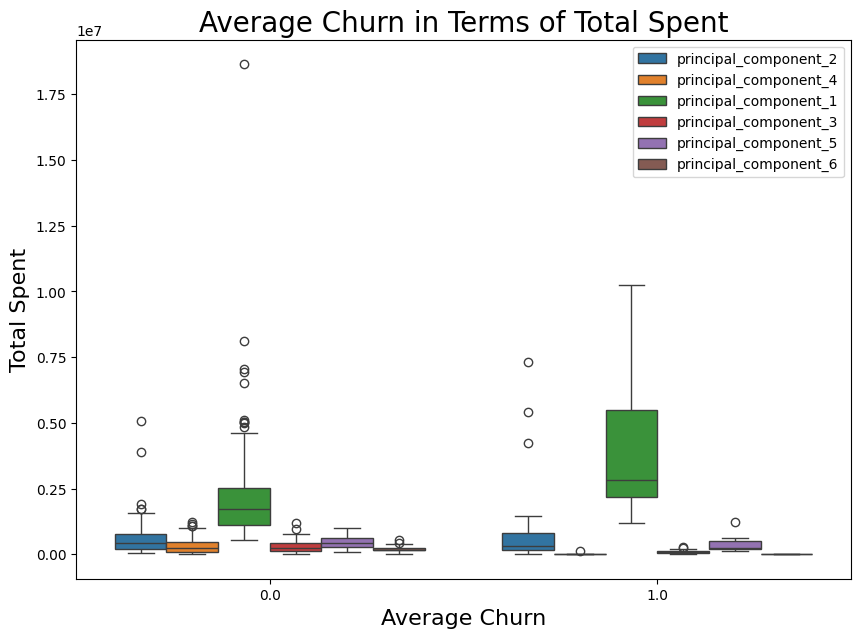

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(10, 7))

sns.boxplot(data=df_pca_churn, hue='principal_component_max', y='total_spent',x='avg_churn')
plt.legend()
plt.title('Average Churn in Terms of Total Spent',size=20)
plt.xlabel('Average Churn',size=16)
plt.ylabel('Total Spent',size=16)

plt.show()

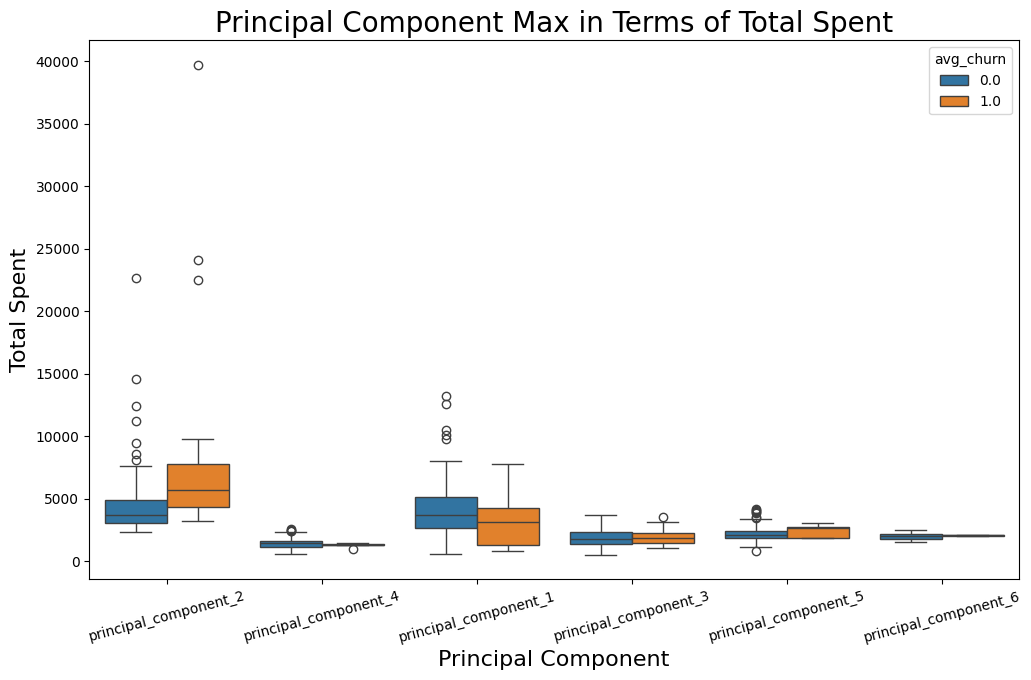

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(12, 7))

sns.boxplot(data=df_pca_churn, x='principal_component_max', y='avg_order_value',hue='avg_churn')
plt.title('Principal Component Max in Terms of Total Spent',size=20)
plt.xlabel('Principal Component',size=16)
plt.xticks(rotation=15)
plt.ylabel('Total Spent',size=16)

plt.show()

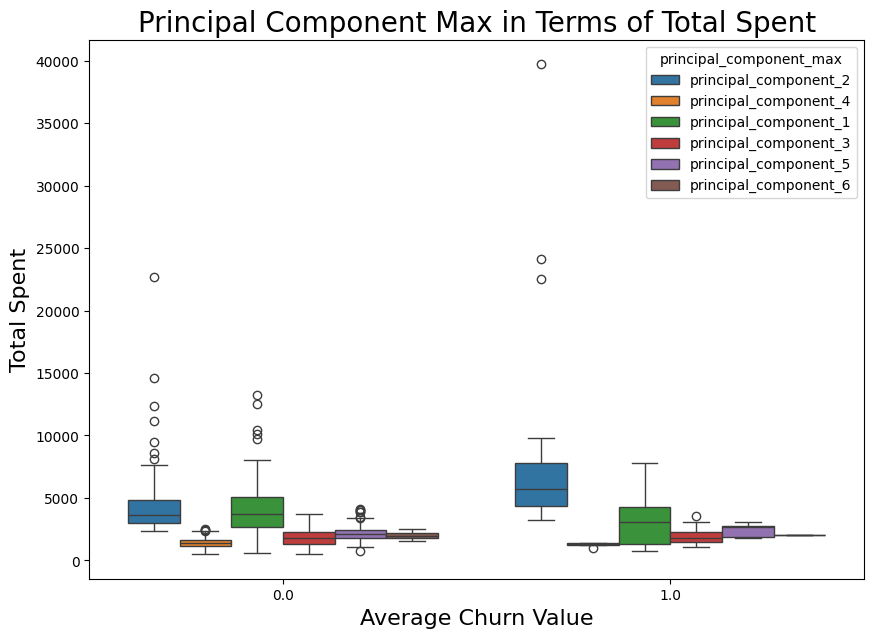

In [ ]:

# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(10, 7))

sns.boxplot(data=df_pca_churn, hue='principal_component_max', y='avg_order_value',x='avg_churn')
plt.title('Principal Component Max in Terms of Total Spent',size=20)
plt.xlabel('Average Churn Value',size=16)
plt.ylabel('Total Spent',size=16)

plt.show()

## **Approach 7: Factorial Analysis**

### Considerations for Factor Analysis:

- Assumptions: Factor Analysis has more strict assumptions about the underlying structure of the data, including the **existence of latent factors** causing the observed correlations.
- Factorability: It's important to assess whether your data is suitable for factor analysis using tests like **Bartlett's Sphericity Test** and the **Kaiser-Meyer-Olkin (KMO) statistic**.
- **Number of Factors**: Determining the appropriate number of factors to extract can be subjective and often involves examining eigenvalues, scree plots (similar to PCA), and interpretability.
- **Rotation**: Factor rotation techniques (like 'varimax') are often used to make the factors more interpretable by simplifying the loadings.

In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=fe4858f8671f0b6e4b2237202cde31a4460a4cca6d0c26a5832e766cb50639a4
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
# Load your dataset
df = pd.read_json("https://raw.githubusercontent.com/vzeizer/Ambev-DataScienceChallenge/master/dataset.json")

df = df.dropna()

# Identify relevant numerical features for PCA
# Consider features related to transactions, spending, and potentially registration date
features_for_fa = ['total_price', 'quantity', 'item_total_price', 'unit_price',
                    ]

customer_features_fa = df.groupby('customer_code').agg(
    total_spent=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    unique_items=('item_code', 'nunique'),
    order_count=('order_id', 'nunique'),
    avg_churn = ('is_churn', 'mean'),
    avg_order_value=('total_price', 'mean'),
    days_since_registration=('register_date', lambda x: (pd.to_datetime('now').tz_localize(None) - pd.to_datetime(x.max()).tz_localize(None)).days if not x.empty else 0)
).reset_index()

# Select the features for FA
fa_features = ['total_spent', 'total_quantity', 'unique_items', 'order_count', 'avg_order_value', 'days_since_registration']
X = customer_features_fa[fa_features].copy().dropna()

# removing outliers
X = X[X['total_spent']<1*10**8]
customer_features_fa = customer_features_fa[customer_features_fa['total_spent']<1*10**8]
#X = X[X['order_count']<1*10**3]
#customer_features_fa = customer_features_fa[customer_features_fa['order_count']<1*10**3]


# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ... (Load data and scale as in the PCA example) ...

# Check for factorability (Bartlett's test and KMO statistic)
chi_square_value, p_value = calculate_bartlett_sphericity(X_scaled)
print("\nBartlett's Sphericity Test:", chi_square_value, p_value)

kmo_all, kmo_model = calculate_kmo(X_scaled)
print("Kaiser-Meyer-Olkin (KMO) Statistic:", kmo_model)

# Apply Factor Analysis
fa = FactorAnalyzer(n_factors=6, rotation='varimax') # Choose number of factors and rotation
fa.fit(X_scaled)

# Factor loadings
loadings_fa = pd.DataFrame(fa.loadings_, index=fa_features, columns=[f'Factor{i+1}' for i in range(6)])
print("\nFactor Loadings (Factor Analysis):")
print(loadings_fa)

# Get the variance explained by each factor
explained_variance_fa = fa.get_factor_variance()
print("\nFactor Variance:")
print(pd.DataFrame(explained_variance_fa, index=['Variance', 'Proportional Var', 'Cumulative Var']))


Bartlett's Sphericity Test: 4398.449788231725 0.0
Kaiser-Meyer-Olkin (KMO) Statistic: 0.5845120586421243

Factor Loadings (Factor Analysis):
                          Factor1   Factor2   Factor3   Factor4   Factor5  \
total_spent              0.433797  0.801483  0.198692  0.170067  0.131195   
total_quantity           0.931058  0.276664 -0.091197  0.154052  0.122324   
unique_items             0.860441  0.152406  0.309971  0.228345 -0.010510   
order_count              0.990123 -0.028086 -0.011712  0.109729 -0.041200   
avg_order_value         -0.025658  0.705711 -0.054377  0.079314 -0.038488   
days_since_registration -0.029726 -0.024159 -0.003482 -0.139411 -0.000978   

                         Factor6  
total_spent                  0.0  
total_quantity               0.0  
unique_items                 0.0  
order_count                  0.0  
avg_order_value              0.0  
days_since_registration      0.0  

Factor Variance:
                         0         1         2         

/usr/local/lib/python3.11/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Create a DataFrame of the principal components
X_scaled = pd.DataFrame(data=X_scaled,
                      columns=[f'factor_analysis_component_{i+1}' for i in range(n_components)])
# create a column that represents the component that has the largest value
X_scaled['factor_analysis_component_max'] = X_scaled[['factor_analysis_component_1', 'factor_analysis_component_2',
                                                              'factor_analysis_component_3','factor_analysis_component_4',
                                                              'factor_analysis_component_5', 'factor_analysis_component_6']].idxmax(axis=1)
#X_scaled = pd.concat([customer_features_fa['customer_code'], X_scaled], axis=1)
X_scaled['customer_code'] = customer_features_fa['customer_code']

In [ ]:
X_scaled.shape

(817, 8)

In [ ]:
customer_features_fa

,customer_code,total_spent,total_quantity,unique_items,order_count,avg_churn,avg_order_value,days_since_registration
0,0,785677.26,1666,52,19,0.0,4389.258436,2536
1,1,1083620.64,3217,50,42,0.0,2300.680764,2624
2,2,841537.44,3204,30,39,0.0,2741.164300,2516
3,3,5102786.19,10124,190,63,0.0,8035.883764,2567
4,4,1076850.86,4383,86,41,0.0,3577.577608,2677
...,...,...,...,...,...,...,...,...
813,832,714118.96,1897,80,26,0.0,2231.621750,2595
814,833,1719164.48,3868,55,27,0.0,5101.378279,2614
815,835,40291.13,239,17,4,0.0,1492.264074,4329
816,836,3169171.10,4379,256,93,1.0,3927.101735,2515


In [ ]:
merge_fa_customer_features = customer_features_fa.merge(X_scaled, on='customer_code')

In [ ]:
merge_fa_customer_features.head()

,customer_code,total_spent,total_quantity,unique_items,order_count,avg_churn,avg_order_value,days_since_registration,factor_analysis_component_1,factor_analysis_component_2,factor_analysis_component_3,factor_analysis_component_4,factor_analysis_component_5,factor_analysis_component_6,factor_analysis_component_max
0,0,785677.26,1666,52,19,0.0,4389.258436,2536,0.041834,0.014488,0.037834,0.006729,0.099233,0.008990,factor_analysis_component_5
1,1,1083620.64,3217,50,42,0.0,2300.680764,2624,0.057825,0.028073,0.036350,0.015327,0.045968,0.035361,factor_analysis_component_1
2,2,841537.44,3204,30,39,0.0,2741.164300,2516,0.044832,0.027959,0.021513,0.014206,0.057202,0.002997,factor_analysis_component_5
3,3,5102786.19,10124,190,63,0.0,8035.883764,2567,0.273536,0.088573,0.140208,0.023178,0.192232,0.018280,factor_analysis_component_1
4,4,1076850.86,4383,86,41,0.0,3577.577608,2677,0.057462,0.038286,0.063056,0.014953,0.078533,0.051244,factor_analysis_component_5


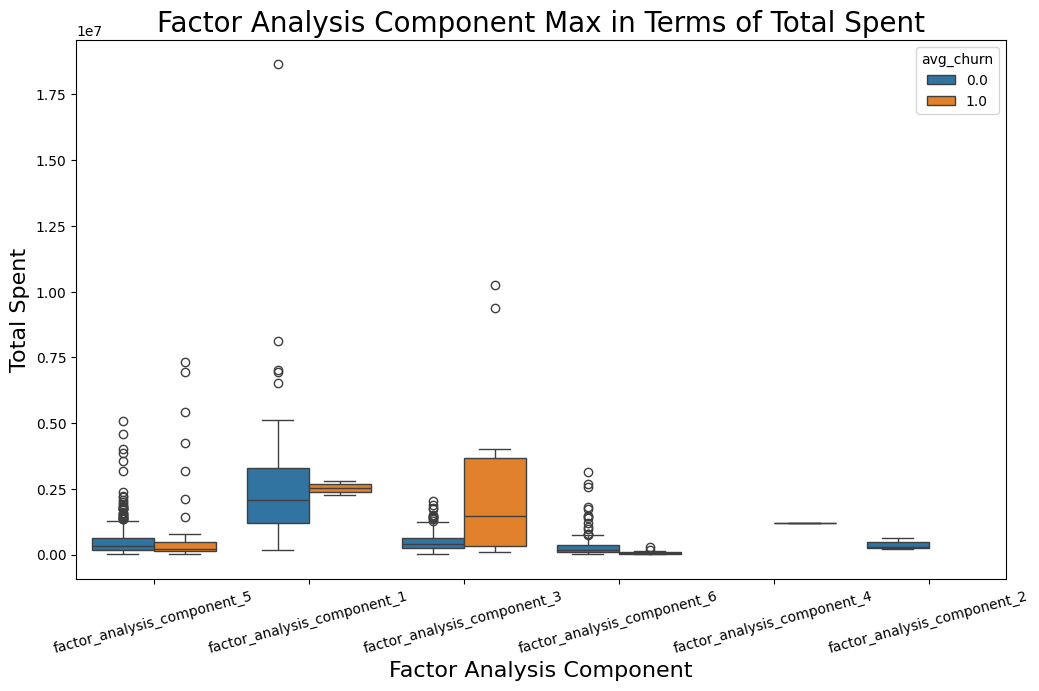

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(12, 7))

sns.boxplot(data=merge_fa_customer_features, x='factor_analysis_component_max', y='total_spent',
            hue='avg_churn')
plt.title('Factor Analysis Component Max in Terms of Total Spent',size=20)
plt.xlabel('Factor Analysis Component',size=16)
plt.ylabel('Total Spent',size=16)
plt.xticks(rotation=15)

plt.show()

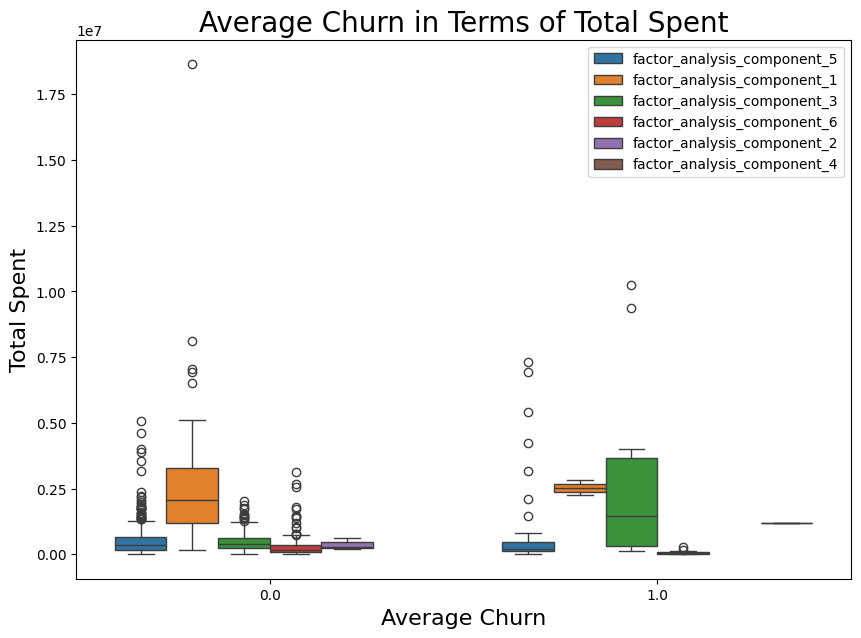

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(10, 7))

sns.boxplot(data=merge_fa_customer_features, hue='factor_analysis_component_max',
            y='total_spent',x='avg_churn')
plt.legend()
plt.title('Average Churn in Terms of Total Spent',size=20)
plt.xlabel('Average Churn',size=16)
plt.ylabel('Total Spent',size=16)

plt.show()

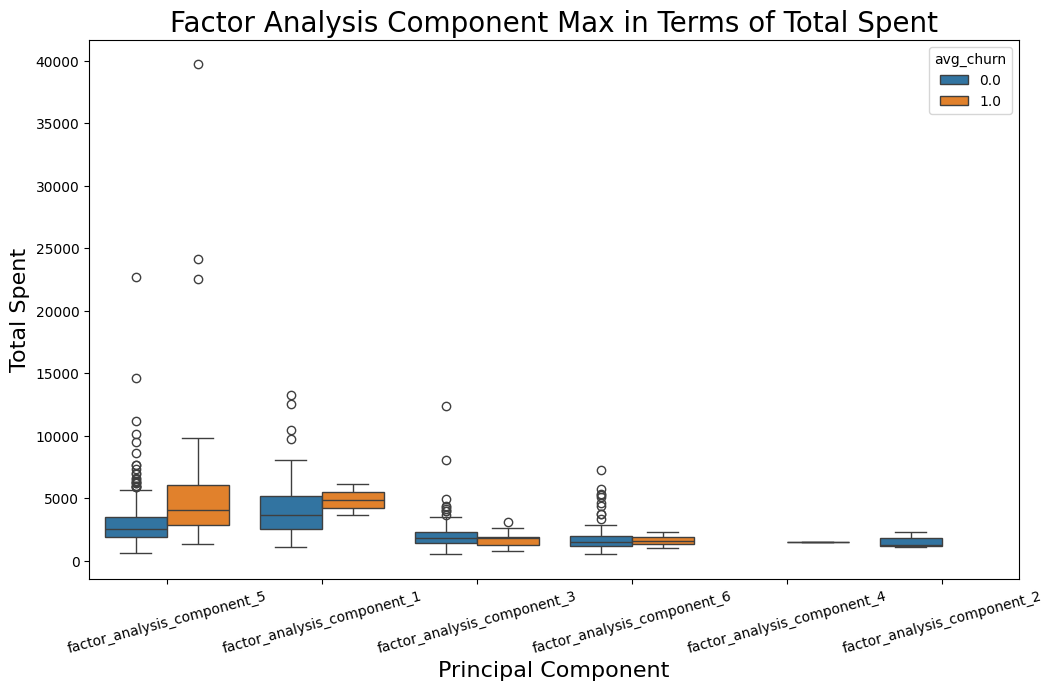

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(12, 7))

sns.boxplot(data=merge_fa_customer_features, x='factor_analysis_component_max', y='avg_order_value',hue='avg_churn')
plt.title('Factor Analysis Component Max in Terms of Total Spent',size=20)
plt.xlabel('Principal Component',size=16)
plt.xticks(rotation=15)
plt.ylabel('Total Spent',size=16)

plt.show()

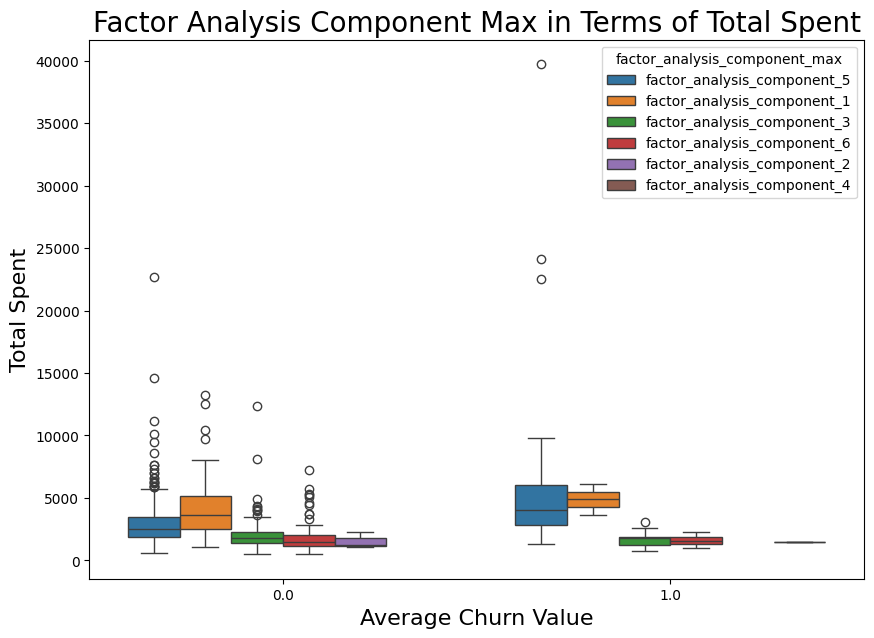

In [ ]:
# in principal_component_max plot the total_spent discriminated by churn
plt.figure(figsize=(10, 7))

sns.boxplot(data=merge_fa_customer_features, hue='factor_analysis_component_max',
            y='avg_order_value',x='avg_churn')
plt.title('Factor Analysis Component Max in Terms of Total Spent',size=20)
plt.xlabel('Average Churn Value',size=16)
plt.ylabel('Total Spent',size=16)

plt.show()